# Corso di Intelligenza Artificiale e Sicurezza - Università degli Studi di Cagliari

## Progetto di Filtering Band Analysis in EEG recognition - Francesco Sechi

### Introduzione - Cosa è l'EGG
L'ElettroEncefaloGramma (d'ora in avanti abbreviato in EEG) è un esame diagnostico, strumentale e non invasivo, che registra le attività elettriche del cervello attraverso una serie di elettrodi posizionati lungo la superficie del cuoio capelluto. L'attività rilevata viene riprodotta sotto forma di una serie di onde, una per ogni elettrodo utilizzato.

<img src="img/EEG.png" width="50%" height="50%">

L'EGG viene utilizzato in ambito medico per la diagnosi di epilessia, tumori al cervello, disturbi cerebrovascolari (ictus, ischemia), disturbi del sonno ed altre patologie cerebrali. 

Tuttavia, negli ultimi anni, è aumentato l'interesse nei confronti dell'utilizzo del segnale dell'EEG come sistema di autenticazione biometrica per una serie di motivi tra cui:
- **Resistenza alla contraffazione:** A differenza di altri tratti biometrici come impronte digitali o iride, le quali possono essere falsificate, l'EEG non è direttamente esposto agli intrusi, rendendolo difficile (se non impossibile) da contraffare.
- **Resistenza agli attacchi di spoofing:** I segnali EEG sono altamente dipendenti dallo stato emotivo del soggetto (quali stress e paura) che modificano i normali pattern delle onde cerebrali, rendendone più difficile l'utilizzo sotto coercizione.
- **Vitalità intrinseca:** Il segnale EEG è rilevabile solo in soggetti vivi, rendendo impossibile l'utilizzo di quest'ultimo in caso di morte del soggetto (a differenza di altri sistemi biometrici).

### Bande di frequenza:
L'esame rileva una serie di bande di frequenza cerebrali differenti:
- **Banda Delta:** Frequenza compresa tra 1 e 4 Hz, identifica stati di sonno profondo (Non-REM), sono predominanti nell'infanzia e assenti nello stato di veglia dell'età adulta. Compaiono in stati di incoscienza come l'anestesia generale.
- **Banda Theta:** Frequenza compresa tra 4 e 8 Hz, dominante nei neonati e in molte patologie crerbali dell'adulto. In condizioni normali si presenta nello stato di dormiveglia, di tensione emotiva e nell'ipnosi.
- **Banda Alpha:** Frequenza compresa tra 8 e 12 Hz, identificano quando il soggetto è sveglio ma in condizione di riposo mentale.
- **Banda Beta:** Frequenza compresa tra 12 e 25 Hz, identificano un soggetto sveglio, con occhi aperti ed impegnato in una qualsiasi attività cerebrale. Si possono rilvare anche durante il sonno in fase REM.
- **Banda Gamma:** Frequenza oltre i 25  Hz, identificano processi cognitivi molto complessi, alta performance fisica e mentale.
- **Banda Broadband:** Frequenza tra 0.5 e un limite superiore, preserva tutte le bande fisiologiche EEG escludendo artefatti non neuronali (inferiori a 1 Hz).

<img src="img/bande_di_frequenza.png" width="50%" height="50%">

### Dataset - [EEG Motor Movement/Imagery (link)](https://physionet.org/content/eegmmidb/1.0.0/)

Il Dataset EEG Motor Movement/Imagery, acquisito presso il [Wadsworth Center, New York State Department of Health](https://pubmed.ncbi.nlm.nih.gov/15188875/) tramite [BCI 2000 (Brain-Computer Interface)](https://www.bci2000.org/mediawiki/index.php/Main_Page), è stato creato per lo sviluppo di sistemi di interfaccia cervello-computer che permettano alle persone di controllare dispositivi esterni attraverso l'attività cerebrale.

Il Dataset è composto da più di 1500 registrazioni di uno o due minuti, ottenute da 109 volontari con l'applicazione di 64 canali e una frequenza di campionamento di 160 Hz.

Il sistema utilizzato per la raccolta del segnale EEG è il SI 1010 con 64 canali di rilevazione. 

<img src="img/64_channel_sharbrough.png" width="40%" height="40%">

*Immagine rappresentate la posizione dei 64 canali utilizzati sui volontari.*

Le registrazioni presenti nel dataset si dividono in tre categorie:
- **T0:** registrazione del segnale EEG del soggetto a riposo;
- **T1:** registrazione del segnale EEG del soggetto durante il movimento del pugno sinistro o di entrambi i pugni
- **T2:** registrazione del segnale EEG del soggetto durante il movimento del pugno destro o di entrambi i piedi

Si utilizzano le registrazioni R01 (categoria T0, Baseline - occhi aperti) per sviluppare un sistema di riconoscimento biometrico basato sui segnali EEG.

In [ ]:
# Librerie necessarie per il corretto funzionamento del notebook
# Se fosse necessario installarle è sufficiente de-commentare la prossima riga:
# %pip install -q -r requirements.txt
# os: Operazioni sul sistema
import os 
# mne: Libreria specifica per segnali EEG      
import mne
# glob: Ricerca di file con pattern specifici 
import glob 
# gdown: Download file da Google Drive
import gdown    
# zipfile: Estrazione e gestione di file .zip
import zipfile
# numpy: Gestione array
import numpy as np
# tqdm: Barre di progresso 
from tqdm import tqdm
# seaborn: grafica
import seaborn as sns
# tensorflow: modelli di deep learning
import tensorflow as tf
# keras_tuner: tuning iperparametri
import keras_tuner as kt
# sklearn.svm: Modello di classificazione SVC
from sklearn.svm import SVC
# matplotlib.pyplot: plot grafici
import matplotlib.pyplot as plt 
# collections: Conteggio
from collections import Counter
# sklearn.metrics: confusion matrix
from sklearn.metrics import confusion_matrix
# sklearn.preprocessing: Standardizzazione
from sklearn.preprocessing import StandardScaler
# sklearn.model_selection: Tuning iperparametri
from sklearn.model_selection import ParameterGrid


## Analisi agente e ambiente

**Agente EEG Recogniser:**
- Agente basato sull'**apprendimento automatico**, in grado di modificare il proprio performance element in base all'interazione con l'ambiente e ai risultati. Inoltre si può definire come agente basato su obiettivi il cui obiettivo è quello di rilevare correttamente l'utente sulla base del segnale EEG.
- Risolve un problema di cui non è noto un algoritmo risolutivo (il riconoscimento biometrico tramite EEG).
- L'ambiente **non è completamente noto** (definito successivamente).

Definizione della struttura dell'agente:
- **Learning element**: Algoritmo di ML o DL (ha lo scopo di migliorare le capacità dell'agente modificando il performance element).
- **Performance element**: Sistema di classificazione incaricato di riconoscere l'identità dell'utente dalla rilevazione EEG (ha lo scopo di indicare l'azione migliore in base alla conoscenza attuale dell'agente).
- **Critico**: Metriche di valutazione (non modificabili dall'agente).
- **Generatore di problemi**: suddivisione per bande di frequenza diverse, segmentazione (ha lo scopo di esplorare soluzioni alternative che possono migliorare il modello in futuro).

**Ambiente:**
- **Prazialmente osservabile**: i segnali EEG sono soggetti a rumore elettrico (apparecchiature, rumore di linea 50 o 60 Hz) e artefatti (movimenti oculari, tensione muscolare); inoltre gli elettrodi sono in grado di rilevare solamente l'attività elettrica superficiale del cervello.
- **Stocastico**: l'attività cerebrale ha componenti casuali e non è completamente prevedibile, anche se esistono pattern identificabili.
- **Episodico**: i vari segmenti creati non influenzano i successivi. Ogni segmento è indipendente.
- **Dinamico**: Le condizioni esterne cambiano col passare del tempo, l'attività cerebrale cambia continuamente.
- **Continuo**: il segnale EEG è continuo sia nel tempo che nella frequenza.

## Preparazione e analisi dei dati

Analisi del dataset per determinare il numero di classi e il numero di campioni per classe.

Si può determinare che il numero di classi corrisponde al numero di volontari (109), mentre il numero di campioni è dato dal numero di campioni acquisiti in totale, dati dalla durata della registrazione EEG per la frequenza di campionamento. 

La maggior parte delle classi ha 9760 campioni, ovvero 160 Hz (frequenza di campionamento) per 61 secondi (durata del campionamento), mentre altre (in numero molto minore) hanno 9600 campioni (causata da una durata di campionamento di un secondo inferiore).

Si utilizza la funzione della libreria mne [```mne.io.read_raw_edf()```](https://mne.tools/stable/generated/mne.io.read_raw_edf.html#mne.io.read_raw_edf) per la lettura dei file .edf (standard europeo). Nel concreto si occupa di leggere un file EDF e convertirlo in file raw mantenendo tutte le informazioni necessarie.

```python
mne.io.read_raw_edf(
    input_fname,        # Percorso del file EDF
    preload=False,      # Opzione per caricare i dati in memoria (RAM) per un accesso più rapido
    verbose=None        # Livello di output verbale ("CRITICAL" per non avere output)
)
```

Si procede con il download del dataset EEG Motor Movement/Imagery dal Google Drive condiviso, contenente un file zip con i file EDF dei 109 volontari della categoria T0 R1.

In [2]:
# Definizione dell'id da cui scaricare le risorse
id = "1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH"
# Download del file da Google Drive come zip
gdown.download(f"https://drive.google.com/uc?id={id}", "dataset/dataset.zip", quiet=False)
# Unzip del file
with zipfile.ZipFile("dataset/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")
# Rimozione del file zip
os.remove("dataset/dataset.zip")

Downloading...
From (original): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH
From (redirected): https://drive.google.com/uc?id=1WwuAh25Jfx-I8rY3vFGyXiI79YfLYUpH&confirm=t&uuid=3672bca0-e0d2-4027-b9af-8a0975d84323
To: c:\Users\franc\Desktop\Progetto\dataset\dataset.zip
100%|██████████| 76.6M/76.6M [00:03<00:00, 24.6MB/s]


In [ ]:
# Raccolta di tutti i percorsi di file EDF che corrispondono al pattern
edf_files_R01 = glob.glob("dataset/EEG_T0/*.edf")
print("Analisi del Dataset:")
# Print del numero totale di utenti (classi)
print(f"Numero totale di classi: {len(edf_files_R01)}")
# Raccolta di tutti i valori
all_samples = []
# Iterazione lungo tutti i file EDF
for edf_file in tqdm(edf_files_R01, desc="Analisi dei file EDF"):
    # Conversione nel formato raw dell'edf_file attuale
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    # Ottenimento dei dati in formato leggibile
    data = raw.get_data()
    # Totale dei campioni per classe registrati
    samples = data.shape[1]
    # Aggiunta ad all_samples per usare Counter successivamente
    all_samples.append(samples)
# Conteggio delle frequenze per campioni
sample_counts = Counter(all_samples)
print(f"\nDistribuzione dei campioni:")
# Iterazione lungo sample_counts e stampa a video dei risultati
for samples, count in sorted(sample_counts.items()):
    print(f"    {samples} campioni: {count} file")
# Ulteriori informazioni utili
print("\nUlteriori informazioni sul Dataset:")
print(f"    Numero di canali: {raw.info['nchan']}")
print(f"    Frequenza di campionamento: {raw.info['sfreq']} Hz")
print(f"    Durata: {raw.times[-1]:.0f} secondi")

Analisi del Dataset:
Numero totale di classi: 109


Analisi dei file EDF: 100%|██████████| 109/109 [00:02<00:00, 39.14it/s]


Distribuzione dei campioni:
    9600 campioni: 4 file
    9760 campioni: 105 file

Ulteriori informazioni sul Dataset:
    Numero di canali: 64
    Frequenza di campionamento: 160.0 Hz
    Durata: 60 secondi


## Implementazione del riconoscitore EEG

### Pre-processing

Si inizia il pre-processing utilizzando il filtro **Butterworth**, standard nel preprocessing dei segnali EEG.

Il filtro Butterworth filtra lungo i segnali compresi tra 0.5 e 40 Hz (segnali cerebrali utili), rimuovendo gli artefatti che possono compromettere la qualità distorcendo il segnale. In questo modo ogni banda filtrata diventa un canale di informazione separato analizzabile indipendentemente.

Il filtro utilizza come limite inferiore 0.5 Hz in modo tale da rimuovere i componenti a frequenza molto bassa che spesso rappresentano artefatti strumentali; mentre 40 Hz come limite superiore per poter includere le onde gamma e allo stesso tempo escludere il rumore muscolare.

Si utilizza il filtro Butterworth per filtrare tutte le bande di frequenza precedentemente definite.

Per implementare il filtro Butterworth si utilizza la funzione della libreria mne [```mne.io.Raw.filter()```](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.filter).


```python
mne.io.Raw.filter(
    l_freq,                 # Frequenza di taglio inferiore
    h_freq,                 # Frequenza di taglio superiore 
    method="iir",           # Tipo di filtro (default per Butterwoth)
    iir_params={            # Dizionario contenente i parametri di IIR
        order:4,            # Ordine del filtro, maggiore è l'ordine
                            # maggiore è "l'aggressività" del filtro.
                            # Lo standard è 4, ottimo compromesso
        ftype: "butter"     # Tipologia di filtro (butter = Butterworth)
    },
    njobs=-1,
    verbose="CRITICAL"       
)
```

Successivamente si effettua un filtraggio spaziale tramite **CAR (Common Average Referencing)** utile per rimuovere il rumore nei casi in cui sono impiegati un  numero elevato di elettrodi, come nel nostro caso.

La formula del filtro CAR è la seguente: $c^u = v^u - {1\over M}\sum^M_{i=1}v^i $, in pratica il potenziale corretto ($c^u$) è dato dal potenziale misurato ($v^u$) meno la media del potenziale di gli elettrodi.

Per implementare il filtro spaziale CAR si utilizza la funzione della libreria mne [```mne.io.Raw.set_eeg_reference()```](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.set_eeg_reference).

```python
mne.io.Raw.set_eeg_reference(
    ref_channels="average", # CAR
    verbose="CRITICAL"
)
```

Infine si effettua una feature extraction usando **PSD (Power Spectral Density) con il metodo Welch**. PSD si occupa di catturare l'informazione più discriminante del segnale cerebrale e ridurre di conseguenza la dimensionalità.
Questa operazione avviene attraverso la Trasformata di Fourier, la quale scompone il segnale cerebrale nelle sue componenti frequenziali.
Infine il metodo Welch stabilizza la stima PSD attraverso l'averaging, ovvero calcola PSD per finestre più piccole di segnale e fa una media delle PSD calcolate.

Fortunatamente, per implementare la feature extraction tramite PSD con il metodo Welch si utilizza la funzione della libreria mne [```mne.time_frequency.psd_array_welch()```](https://mne.tools/stable/generated/mne.time_frequency.psd_array_welch.html).

La funzione divide i campioni di ogni canale in finestre sovrapposte (definite dal valore di n_per_seg). Ogni finestra viene processata con la Trasformata di Fourier (con eventuale zero-padding se n_fft > n_per_seg) per ottenere lo spettro di potenza. Le PSD delle varie finestre vengono mediate per ottenere una stima più stabile. Il risultato è un vettore di PSD per ogni canale, con dimensionalità (canali, n_freqs), che può essere ulteriormente ridotta mediando lungo le frequenze.

Nel concreto l'input ha dimensionalità (64, 240) (64 canali, 240 campioni), una volta effettuata la feature extraction tramite PSD si ottiene in output una matrice di dimensioni (64, n_freqs) (n_freqs è il numero di bins di frequenze generati dalla Trasformata di Fourier) che viene ulteriormente ridotta mediando lungo n_freqs ed ottenendo dimensione (64), ovvero una feature per canale.

```python
psd, _ = mne.time_frequency.psd_array_welch(
    x,                      # Input data da passare a PSD
    sfreq,                  # Frequenza di campionamento          
    fmin,                   # Frequenza bassa
    fmax,                   # Frequenza alta
    n_fft,                  # Lunghezza FFT (Trasformata di Fourier)
    n_per_seg,              # Lunghezza della finestra  
    n_overlap,              # Sovrapposizione tra finestre
    n_jobs=-1,
    verbose="CRITICAL"      
)
```

Riassumendo, si eseguono i seguenti passaggi:
- Suddivisione del segnale EEG in bande di frequenza predefinite con l'aggiunta finale della banda broadband.
- Si applica il filtro Butterworth per ogni banda e per la banda broadband (con limite inferiore e superiore rispettivamente di 0.5 e 40 hz).
- Si applica il filtro spaziale CAR.
- Si segmentano i vari record preprocessati in campioni da 1.5 secondi.
- Si effettua la Feature Extraction tramite PSD con il metodo Welch.
- Si suddividono i campioni preprocessati in 70% per l'addestramento, 15% per la validazione e 15% per il test.

Si ottengono così sei differenti Dataset per l'autenticazione biometrica tramite EEG (Delta, Theta, Alpha, Beta, Gamma, Broadband) da confrontare. 

Successivamente si prosegue implementando un modello [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (si utilizza la libreria scikit learn) per il riconoscimento biometrico tramite segnale EEG opportunamente preprocessato. Si effettua un tuning degli iperparametri tramite la funzione [```ParameterGrid```](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) per ottenere il miglior classificatore possibile.

Prima di passare i dati al classificatore SVC si utilizza la funzione [```StandardScaler```](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) per standardizzare i campioni con media = 0 e deviazione standard = 1, essenziale per garantire buone prestazione del SVC.

In [4]:
# Funzione per il preprocessing dei file EDF (Butterworth - CAR) e restituzione dei dati raw
def preprocessing(edf_file, low, high, band):
    # Conversione nel formato raw dell'edf_file attuale
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    # Preprocessing: filtraggio tramite Butterworth 
    raw.filter(l_freq=low[band], h_freq=high[band], method="iir", iir_params={"order": 4, "ftype": "butter"}, n_jobs=-1, verbose="CRITICAL")
    # Preprocessing: filtraggio spaziale tramite CAR
    raw.set_eeg_reference("average", verbose="CRITICAL")
    # Ottenimento dei dati in formato leggibile
    data = raw.get_data()   
    # Restituzione dei dati raw
    return data

# Funzione per  la segmentazione ed il calcolo di PSD (pre-processing)
def PSD(samples, data, freq, low, high, band):
    # Totale dei campioni registrati per file
    tot_samples = data.shape[1]
    # Numero tot di segmenti per file 
    tot_segments = tot_samples // samples # 40
    # Feature Extraction: Riduzione della dimensionalità con PSD e Segmentazione
    # Lista per contenere i campioni estratti tramite feature extraction
    feature_extraction = []
    # Iterazione lungo tutti i segmenti
    for i in range(tot_segments):
        # Inizializzazione di start e end
        start = i * samples
        end = start + samples
        if end <= tot_samples:
            # Per tutti i canali considera solo i dati del segmento attuale
            segment = data[:, start:end]
            # Si ottiene la psd con metodo Welch (averaging)
            psd, _ = mne.time_frequency.psd_array_welch(segment, sfreq=freq, fmin=low[band], fmax=high[band], n_fft=128, n_per_seg=120, n_overlap=60, n_jobs=-1, verbose="CRITICAL")
            # Estrazione della media per ogni canale
            psd_features = np.mean(psd, axis=1)
            # Aggiunta del segmento post-feature extraction alla lista
            feature_extraction.append(psd_features)
        else:
            break
    # Restituzione della lista contenente i segmenti post-feature extraction
    return feature_extraction

# Funzione generale per il pre-processing dei dati EEG
def process_eeg_data(edf_files, bands, low, high, freq, samples):
    # Inizializzazione dei dizionari per train/val/test
    X_train = {}
    y_train = {}
    X_val = {}
    y_val = {}
    X_test = {}
    y_test = {}
    # Iterazione che permette il filtraggio dei dati per ogni banda, 
    # la successiva segmentazione e il salvataggio dei dati in variabili separate.
    for band in bands:
        print(f"Pre-processing (Butterworth - CAR - PSD) banda {band}:")
        # Inizializzazione liste per train/val/test
        train_datas = []
        train_labels = []
        val_datas = []
        val_labels = []
        test_datas = []
        test_labels = []
        # Iterazione lungo i file EDF per la segmentazione
        for label, edf_file in tqdm(enumerate(edf_files), desc=f"   File EDF", leave=False, total=len(edf_files)): 
            # Chiamata alla funzione preprocessing() (Butterworth - CAR)
            data = preprocessing(edf_file, low, high, band)
            # Feature Extraction: Segmentazione e riduzione della dimensionalità con PSD
            # Lista per contenere i campioni estratti tramite feature extraction 
            feature_extraction = PSD(samples, data, freq, low, high, band)
            # Numero totale degli elementi per segmento
            elements = len(feature_extraction)
            # Train set, validation set e test set split
            if elements > 0:
                # Calcolo dei punti di split (70% train, 15% val, 15% test)
                # Primo 70% dei campioni per il train set
                train_end = int(elements * 0.7)
                # Successivo 15% dei campioni per il validation set
                val_end = int(elements * 0.85)
                # Costruzione del segmento di train (X e y)
                train_datas.extend(feature_extraction[:train_end])               
                train_labels.extend([label] * train_end)
                # Costruzione del segmento di validation (X e y)
                val_datas.extend(feature_extraction[train_end:val_end])
                val_labels.extend([label] * (val_end - train_end))
                # Costruzione del segmento di test (X e y)
                test_datas.extend(feature_extraction[val_end:])
                test_labels.extend([label] * (elements - val_end))
        # Creazione degli array numpy per la rispettiva banda
        X_train[band] = np.array(train_datas)
        y_train[band] = np.array(train_labels)
        X_val[band] = np.array(val_datas)
        y_val[band] = np.array(val_labels)
        X_test[band] = np.array(test_datas)
        y_test[band] = np.array(test_labels)
        # Stampa dello shape per controllare la dimensione 
        # Output atteso:
        # Shape X_train: (3052, 64)
        # Shape X_val:   (654, 64)
        # Shape X_test:  (654, 64)
        print(f"Shape X_train di {band}: {X_train[band].shape}")
        print(f"Shape X_val di {band}: {X_val[band].shape}")
        print(f"Shape X_test di {band}: {X_test[band].shape}\n")
    # Restituzione dei dizionari contenenti i dati di train, validation e test
    return X_train, y_train, X_val, y_val, X_test, y_test

# Frequenze basse per ogni banda
low = {"alpha" : 8, "beta" : 12, "delta" : 1, "gamma" : 25, "theta" : 4, "broadband" : 0.5 }
# Frequenze alte per ogni banda
high = {"alpha" : 12, "beta" : 25, "delta" : 4, "gamma" : 40, "theta" : 8, "broadband" : 40 }
# Lista delle bande
bands = ["alpha", "beta", "gamma", "delta", "theta", "broadband"]
# Secondi per la segmentazione dell'EEG
seconds = 1.5
# Frequenza di campionamento
freq = raw.info["sfreq"] # 160 Hz
# Calcolo dei campioni per segmento
samples_segment = int(seconds * freq) # 240 samples
# Chiamata alla funzione generale per il pre-processing dei dati EEG
X_train_R01, y_train_R01, X_val_R01, y_val_R01, X_test_R01, y_test_R01 = process_eeg_data(edf_files_R01, bands, low, high, freq, samples_segment)

Pre-processing (Butterworth - CAR - PSD) banda alpha:


Shape X_train di alpha: (3052, 64)
Shape X_val di alpha: (654, 64)
Shape X_test di alpha: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda beta:


Shape X_train di beta: (3052, 64)
Shape X_val di beta: (654, 64)
Shape X_test di beta: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda gamma:


Shape X_train di gamma: (3052, 64)
Shape X_val di gamma: (654, 64)
Shape X_test di gamma: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda delta:


Shape X_train di delta: (3052, 64)
Shape X_val di delta: (654, 64)
Shape X_test di delta: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda theta:


Shape X_train di theta: (3052, 64)
Shape X_val di theta: (654, 64)
Shape X_test di theta: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda broadband:


Shape X_train di broadband: (3052, 64)
Shape X_val di broadband: (654, 64)
Shape X_test di broadband: (654, 64)



In [5]:
# Funzione per la standardizzazione dei dati per poterli passare al classificatore shallow (SVC)
def standardization(bands, X_train, X_val, X_test):
    # Standardizzazione dei dati da passare a SVC
    for band in bands:
        # Definizione dello scaler
        scaler = StandardScaler()
        # Standardizzazione dei dati di train
        X_train[band] = scaler.fit_transform(X_train[band])
        # Applicazione dei risultati ai dati di validation e test
        X_val[band] = scaler.transform(X_val[band])
        X_test[band] = scaler.transform(X_test[band])

# Funzione per il tuning degli iperparametri del modello shallow (SVC)
def hyperparameter_tuning_SVC(param_grids, bands, X_train, y_train, X_val, y_val):
    # Dizionari per tracciare i risultati migliori
    best_models = {}
    best_scores = {}

    # Iterazione lungo le bande
    for band in bands:
        print(f"Valutazione del modello SVC della banda {band}:")
        # Inizializzazione variabili per i migliori risultati
        best_score_band = 0
        best_params_band = {}
        best_model_band = None
        # Iterazione lungo param_grids (test su tutti i parametri considerati)
        for param_grid in param_grids:
            # Stampa a video per verificare il kernel attuale considerato
            print(f"    Valutazione del miglior modello con il kernel {param_grid['kernel'][0]}...")
            # Iterazione lungo le differenti combinazioni di parametri
            for params in ParameterGrid(param_grid):
                # Definzione del classificatore SVC su cui effettuare il tuning degli iperparametri.
                # Si imposta random state=21 per la riproducibilità
                clf = SVC(**params, random_state=21)
                # Addestramento del classificatore sui dati di train
                clf.fit(X_train[band], y_train[band])
                # Valutazione dell'accuracy sui dati di validation
                accuracy = clf.score(X_val[band], y_val[band]) 
                # Aggiornamento dei risultati migliori
                if accuracy > best_score_band:
                    best_score_band = accuracy
                    best_params_band = params.copy()  
                    best_model_band = clf
        # Salvataggio dei migliori modelli per la banda attuale
        best_models[band] = best_model_band
        best_scores[band] = best_score_band
        # Stampa a video dei risultati migliori attuali
        print(f"\nRisultati banda {band}:")
        print(f"    Migliori parametri: {best_params_band}")
        print(f"    Accuracy: {best_score_band:.4f}\n")
    # Restituzione dei migliori modelli e risultati migliori
    return best_models, best_scores

# Definizione una lista dei parametri di C da testare 
# tipicamente su scale logaritmiche, si usa logspace di numpy
c = np.logspace(-2, 1, 4) # [0.01, 0.1, 1, 10]
# Definizione di una lista dei parametri di gamma da testare
# tipicamente su scale logaritmiche, si usa logspace di numpy
gamma = ['scale', 'auto'] + list(np.logspace(-3, 1, 5))  # [0.001, 0.01, 0.1, 1, 10]
# Definizione dei parametri degree da testare per kernel poly
degree = [2, 3]
# Definzione dei parametri diversi per kernel (linear, rbf, poly)
linear_params = {
    "kernel": ['linear'], 
    "C": c}
rbf_params = {
    "kernel": ['rbf'], 
    "C": c, 
    "gamma": gamma}
poly_params = {
    "kernel": ['poly'],
    "C": c,
    "degree": degree,
    "gamma": gamma}
# Definizione del parametro param_grid come combinazione degli iperparametri dei vari kernel da valutare
param_grids = [linear_params, rbf_params, poly_params]
# Chiamata alla funzione di standardizzazione
standardization(bands, X_train_R01, X_val_R01, X_test_R01)
# Chiamata alla funzione per il tuning degli iperparametri del modello shallow (SVC)
best_models_R01, best_scores_R01 = hyperparameter_tuning_SVC(param_grids, bands, X_train_R01, y_train_R01, X_val_R01, y_val_R01)

Valutazione del modello SVC della banda alpha:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda alpha:
    Migliori parametri: {'C': 10.0, 'kernel': 'linear'}
    Accuracy: 0.6636

Valutazione del modello SVC della banda beta:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda beta:
    Migliori parametri: {'C': 10.0, 'kernel': 'linear'}
    Accuracy: 0.9404

Valutazione del modello SVC della banda gamma:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda gamma:
    Migliori parametri: {'C': 10.0, 'kernel': 'linear'}
    Accuracy: 0.9786

Valutazione del modello SVC de

In [6]:
# Funzione per stampare a video il confronto tra i risultati di validation e test
def val_test_comparison(bands, best_models, best_scores, X_test, y_test, directory):
    # Stampa ordinata con distanziamento. Le scritte sono centrate
    print(f"| {'Banda':^12} | {'Validation':^12} | {'Test':^12} |")
    # Stampa del separatore (estetico)
    print("-"*46)
    # Definizione della lista contenente i risultati
    results = []
    # Iterazione lungo le bande
    for band in bands:
        # Risultato dell'accuratezza sul test set
        test_accuracy = best_models[band].score(X_test[band], y_test[band])
        # Aggiunta dei risultati (banda - validation test accuracy - test set accuracy)
        # alla lista dei risultati
        results.append((band, best_scores[band], test_accuracy))
    # Sort decrescente (dal migliore al peggiore) per accuracy sul test set
    results.sort(key=lambda x: x[2], reverse=True)
    # Iterazione lungo la lista dei risultati e scomposizione dei valori all'interno
    for band, val_acc, test_acc in results:
        # Stampa ordinata che segue la precedente per mantenere ordine
        # I valori di accuratezza sul validation set e test set sono
        # stampati con quattro valori decimali
        print(f"| {band:^12} | {val_acc:^12.4f} | {test_acc:^12.4f} |")
    print()
    # Definizione della directory da creare
    dir = directory
    # Impostazione del percorso della cartella principale per
    # contenere le varie sottocartelle delle confusion matrix
    path_dir = os.path.join(os.getcwd(), f"confusion_matrix/{dir}")
    # Se il percorso attuale non esiste viene creato
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)
    # Iterazione lungo le bande
    for band in bands:
        # Definizione del file path dove salvare le matrici di confusione
        file_path = f"confusion_matrix/{dir}/{band}_cm.png"
        # Se il file path non esiste si procede con la creazione
        if not os.path.exists(file_path):
            # Stampa a video per verificare il corretto funzionamento
            print(f"Generazione matrice di confusione banda {band}...")
            # Generazione dell'immagine 
            plt.figure(figsize=(12, 10))
            # Predizioni del modello
            y_pred = best_models[band].predict(X_test[band])
            y_true = y_test[band]
            # Calcolo dell matrice di confusione
            cm = confusion_matrix(y_true, y_pred)
            # Plot della matrice di confusione con colorazione blu
            sns.heatmap(cm, cmap="Blues")
            # Definizione del titolo personalizzato e definzione degli assi x e y
            plt.title(f"Confusion Matrix - Banda {band}")
            plt.xlabel("Classe Predetta")
            plt.ylabel("Classe Reale")
            # Salvataggio dell'immagine nel percorso predefinito e chiusura (per evitare la stampa a video)
            plt.savefig(file_path)
            plt.close()
            # Controllo con stampa a video
            print("Matrice di confusione salvata.")
        # Se la matrice di confusione è già stata generata
        else:
            # Stampa un messaggio di controllo
            print(f"Matrice di confusione della banda {band} già generata.")
    # Controllo finale
    print(f"\nGenerate tutte le matrici di confusione, sono visibili nella cartella {dir}")
    # Restituzione della lista dei risultati
    return results
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione
results_R01 = val_test_comparison(bands, best_models_R01, best_scores_R01, X_test_R01, y_test_R01, "CM_R01")

|    Banda     |  Validation  |     Test     |
----------------------------------------------
|    gamma     |    0.9786    |    0.9740    |
|     beta     |    0.9404    |    0.9343    |
|  broadband   |    0.9281    |    0.9067    |
|    delta     |    0.7783    |    0.7569    |
|    theta     |    0.7339    |    0.7232    |
|    alpha     |    0.6636    |    0.6407    |

Generazione matrice di confusione banda alpha...
Matrice di confusione salvata.
Generazione matrice di confusione banda beta...
Matrice di confusione salvata.
Generazione matrice di confusione banda gamma...
Matrice di confusione salvata.
Generazione matrice di confusione banda delta...
Matrice di confusione salvata.
Generazione matrice di confusione banda theta...
Matrice di confusione salvata.
Generazione matrice di confusione banda broadband...
Matrice di confusione salvata.

Generate tutte le matrici di confusione, sono visibili nella cartella CM_R01


## Analisi dei risultati

La banda di frequenza **Alpha**, è per definizione la frequenza dominante in stati di riposo o occhi chiusi, di conseguenza sarebbe dovuta essere la frequenza con il risultato atteso maggiore, tuttavia essendo il task utilizzato per la rilevazione dell'EEG ti tipo REO (Eyes Open), la banda di frequenza Alpha (solitamente rilevata dagli elettrodi della zona parietale) è stata soppressa e dominata dalla rilevazione di frequenza della zona centrale. Passando così da essere quella con il risultato atteso maggiore alla meno performante (Si può anche notare dalla confusion matrix, la quale risulta essere particolarmente disordinata).

Le bande di frequenza **Theta** e **Delta**, non essendo per definizione presenti nel task utilizzato ed in generale negli adulti se non in casi particolari, non risultavano essere interessanti o sufficientemente discriminanti ancor prima di iniziare l'analisi, ed hanno confermato l'ipotesi.

Il risultato ottenuto dalla banda di frequenza **Beta**, è (probabilmente) conseguenza diretta della tipologia di task utilizzato e spiega la bassa accuratezza rilevata dalla banda di frequenza Alfa , si ipotizza dunque che sia la banda di frequenza maggiormente rappresentativa per il task REO, in quanto è associata ad un soggetto sveglio con occhi aperti.

I risultati della banda **Gamma** sono inattesi essendo la banda di frequenza Gamma associata per definizione a processi cognitivi complessi (non riscontrabili nel task REO a riposo). 

Tuttavia, andando a vedere le definizioni della neuroscienza in ambito di bande di frequenza ed EEG, si possono fare una serie di considerazioni. 
Con attività EEG si intende qualsiasi onda o sequenza di onde EEG. In genere suddivisa in attività lenta (attività di frequenza minore dell’Alfa, cioè attività Theta e/o Delta) e attività rapida (attività di frequenza maggiore dell’alfa, cioè attività beta) ([*Elettroencefalografia Standard e Prove di Attivazione, Appendice B, Attività EEG.*](https://www.lice.it/LICE_ita/gruppi/pdf/EEGinEpil-def.pdf)).

Inoltre la banda gamma risulta avere valori molto maggiori secondo la neuroscienza rispetto a quelli definiti precedentemente (30-80Hz) ([*Elettroencefalografia Standard e Prove di Attivazione, Appendice B, Banda*](https://www.lice.it/LICE_ita/gruppi/pdf/EEGinEpil-def.pdf)), di conseguenza è possibile ipotizzare che la banda di frequenza **Gamma** sia invece una banda di frequenza **Beta** "allargata".

La distinzione netta tra attività lenta ed attività rapida (si noti l'assenza della banda di frequenza Gamma) corrisponde alla distinzione tra le bande di frequenza che hanno riportato valori di accuratezza ottimi (Gamma, Beta) e valori di accuratezza insufficienti (Alfa, Theta, Delta), l'ipotesi avanzata è dunque che le bande di frequenza comprendenti attività lente non siano sufficientemente informative e discriminanti. 

In conclusione, la banda di frequenza **Broadband**, pur mantenendo un elevata accuratezza risulta leggermente inferiore alle bande di frequenza Gamma e Beta, questo è probabilmente causato dal rumore aggiunto delle attività lente che degradano i risultati. 

## Componente Avanzata: esplorazione e analisi di problemi aperti

Visti i risultati ottenuti e le ipotesi avanzate, come prima analisi si effettua il medesimo preprocessing e la medesima divisione per bande di frequenza sui dati del task T0 R02 REC (Eyes Closed), i dati sono disponibili nella cartella "EEG_R02". 

In [7]:
# Raccolta di tutti i perorsi di file EDF che corrispondono al pattern
edf_files_R02 = glob.glob("dataset/EEG_R02/*.edf")
# Chiamata alla funzione di pre-processing dei dati EEG (Butterworth - CAR - Segmentazione - PSD)
X_train_R02, y_train_R02, X_val_R02, y_val_R02, X_test_R02, y_test_R02 = process_eeg_data(edf_files_R02, bands, low, high, freq, samples_segment)
# Chiamata alla funzione di standardizzazione dei dati per passarli successivamente al modello shallow (SVC)
standardization(bands, X_train_R02, X_val_R02, X_test_R02)
# Chiamata alla funzione per il tuning degli iperparametri del modello shallow (SVC)
best_models_R02, best_scores_R02 = hyperparameter_tuning_SVC(param_grids, bands, X_train_R02, y_train_R02, X_val_R02, y_val_R02)
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione
results_R02 = val_test_comparison(bands, best_models_R02, best_scores_R02, X_test_R02, y_test_R02, "CM_R02")

Pre-processing (Butterworth - CAR - PSD) banda alpha:


Shape X_train di alpha: (3052, 64)
Shape X_val di alpha: (654, 64)
Shape X_test di alpha: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda beta:


Shape X_train di beta: (3052, 64)
Shape X_val di beta: (654, 64)
Shape X_test di beta: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda gamma:


Shape X_train di gamma: (3052, 64)
Shape X_val di gamma: (654, 64)
Shape X_test di gamma: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda delta:


Shape X_train di delta: (3052, 64)
Shape X_val di delta: (654, 64)
Shape X_test di delta: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda theta:


Shape X_train di theta: (3052, 64)
Shape X_val di theta: (654, 64)
Shape X_test di theta: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda broadband:


Shape X_train di broadband: (3052, 64)
Shape X_val di broadband: (654, 64)
Shape X_test di broadband: (654, 64)

Valutazione del modello SVC della banda alpha:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda alpha:
    Migliori parametri: {'C': 10.0, 'kernel': 'linear'}
    Accuracy: 0.6147

Valutazione del modello SVC della banda beta:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda beta:
    Migliori parametri: {'C': 10.0, 'kernel': 'linear'}
    Accuracy: 0.8976

Valutazione del modello SVC della banda gamma:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda ga

In [8]:
# Creazione di due dizionari per il confronto tra R01 e R02
dict_R01 = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_R01}
dict_R02 = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_R02}
# Stampa ordinata con distanziamento. Le scritte sono centrate
print(f"| {'Banda':^12} | {'R01 Val':^12} | {'R02 Val':^12} | {'Diff Val':^12} | {'R01 Test':^12} | {'R02 Test':^12} | {'Diff Test':^12} |")
# Stampa a video del separatore (estetica)
print("-"*106)
# Iterazione lungo le band di R01
for band in dict_R01.keys():
    # Validation accuracy e test accuracy di entrambi i dataset (divisi per banda)
    val_R01, test_R01 = dict_R01[band]
    val_R02, test_R02 = dict_R02[band]
    # Calcolo differenze validation accuracy tra dataset e test accuracy tra dataset
    diff_val = val_R02 - val_R01
    diff_test = test_R02 - test_R01
    # Stampa ordinata che segue la precedente per mantenere ordine
    # I valori di accuratezza sul validation set e test set sono stampati con quattro valori decimali
    print(f"| {band:^12} | {val_R01:^12.4f} | {val_R02:^12.4f} | {diff_val:^+12.4f} | {test_R01:^12.4f} | {test_R02:^12.4f} | {diff_test:^+12.4f} |")

|    Banda     |   R01 Val    |   R02 Val    |   Diff Val   |   R01 Test   |   R02 Test   |  Diff Test   |
----------------------------------------------------------------------------------------------------------
|    gamma     |    0.9786    |    0.9480    |   -0.0306    |    0.9740    |    0.9327    |   -0.0413    |
|     beta     |    0.9404    |    0.8976    |   -0.0428    |    0.9343    |    0.8670    |   -0.0673    |
|  broadband   |    0.9281    |    0.9266    |   -0.0015    |    0.9067    |    0.8976    |   -0.0092    |
|    delta     |    0.7783    |    0.8226    |   +0.0443    |    0.7569    |    0.7844    |   +0.0275    |
|    theta     |    0.7339    |    0.7676    |   +0.0336    |    0.7232    |    0.7401    |   +0.0168    |
|    alpha     |    0.6636    |    0.6147    |   -0.0489    |    0.6407    |    0.5856    |   -0.0550    |


Analizzando i risultati ottenuti si può affermare che la banda di frequenza **Alpha**, nonostante il task utilizzato sia specifico per la sua rilevazione, non risulta essere nemmeno questa volta sufficientemente discriminante. Inoltre le bande di frequenza **Theta** e **Delta** risultano nuovamente non essere sufficientemente discriminanti. 

L’ipotesi sulla banda di frequenza è quindi smentita, inoltre è confermato che le bande di frequenza Theta e Delta non sono sufficientemente discriminanti, mentre le bande di frequenza Beta, Gamma e Broadband risultano essere le migliori.

Per procedere con l'analisi avanzata si considerano solamente le bande di frequenza più interessanti e potenzialmente applicabili, ovvero **Gamma**, **Beta** e **Broadband**, che confermano un'accuratezza superiore al 90% (R01).

Si considerano due nuove bande di frequenza:
- banda di frequenza **Beta + Gamma**, data dalla combinazione delle due bande con accuratezza maggiore, compresa tra 12 e 40Hz.
- banda di frequenza **Beta rapido**, come definita dalla neuroscienza ([*Elettroencefalografia Standard e Prove di Attivazione, Appendice B, Banda*](https://www.lice.it/LICE_ita/gruppi/pdf/EEGinEpil-def.pdf)), compresa tra 18 e 30Hz.

In [9]:
# Definizione di due nuove bande di frequenza da testare
bands_BG = ["beta + gamma", "beta rapido"]
# Nuove basse frequenze
low_BG = {"beta + gamma": 12, "beta rapido": 18}
# Nuove alte frequenze 
high_BG = {"beta + gamma": 40, "beta rapido": 30}
# Chiamata alla funzione di pre-processing dei dati EEG (Butterworth - CAR - Segmentazione - PSD)
X_train_BG, y_train_BG, X_val_BG, y_val_BG, X_test_BG, y_test_BG = process_eeg_data(edf_files_R01, bands_BG, low_BG, high_BG, freq, samples_segment)
# Chiamata alla funzione di standardizzazione dei dati per passarli successivamente al modello shallow (SVC)
standardization(bands_BG, X_train_BG, X_val_BG, X_test_BG)
# Chiamata alla funzione per il tuning degli iperparametri del modello shallow (SVC)
best_models_BG, best_scores_BG = hyperparameter_tuning_SVC(param_grids, bands_BG, X_train_BG, y_train_BG, X_val_BG, y_val_BG)
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione
results_BG = val_test_comparison(bands_BG, best_models_BG, best_scores_BG, X_test_BG, y_test_BG, "CM_R01")

Pre-processing (Butterworth - CAR - PSD) banda beta + gamma:


Shape X_train di beta + gamma: (3052, 64)
Shape X_val di beta + gamma: (654, 64)
Shape X_test di beta + gamma: (654, 64)

Pre-processing (Butterworth - CAR - PSD) banda beta rapido:


Shape X_train di beta rapido: (3052, 64)
Shape X_val di beta rapido: (654, 64)
Shape X_test di beta rapido: (654, 64)

Valutazione del modello SVC della banda beta + gamma:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda beta + gamma:
    Migliori parametri: {'C': 10.0, 'kernel': 'linear'}
    Accuracy: 0.9755

Valutazione del modello SVC della banda beta rapido:
    Valutazione del miglior modello con il kernel linear...
    Valutazione del miglior modello con il kernel rbf...
    Valutazione del miglior modello con il kernel poly...

Risultati banda beta rapido:
    Migliori parametri: {'C': 1.0, 'kernel': 'linear'}
    Accuracy: 0.9557

|    Banda     |  Validation  |     Test     |
----------------------------------------------
| beta + gamma |    0.9755    |    0.9648    |
| beta rapido  |    0.9557    |    0.9343    |

Generazione matrice

L'unione della bande di frequenza **Beta** e **Gamma** restituisce dati interessanti, elevata accuratezza, anche se leggermente inferiori rispetto la banda di frequenza **Gamma** considerata singolarmente. Si inserisce tra le bande di frequenza da considerare per le successive analisi.

La banda di frequenza **Beta rapido** mostra sempre risultati ottimali pur rimanendo inferiore.

### Riduzione dei canali

Si procede con la riduzione dei canali, principale ostacolo nell'applicazione reale dell'autenticazione biometrica basata su EEG, l'obiettivo è mantenere livelli di accuratezza elevati con un numero sempre minore di elettrodi.

La riduzione verificata è il passaggio dal sistema 10-10 (64 canali) al sistema 10-20 ([*Elettroencefalografia Standard e Prove di Attivazione, Capitolo A Elettrodi e Montaggi, Paragrafo 2.*](https://www.lice.it/LICE_ita/gruppi/pdf/EEGinEpil-def.pdf)), che secondo lo standard internazionale comprende i seguenti elettrodi:
- A destra: Fp2, F4, F8, C4, P4, T4, T6, O2.
- A sinistra: Fp1, F3, F7, C3, P3, T3, T5, O1.
- Linea mediana: Fz, Cz, Pz.
- Riferimento: A2, A1.

Gli elettrodi T3 e T4 del sistema 10-20 corrispondono agli elettrodi T7 e T8 del sistema 10-10, mentre gli elettrodi P7 e P8 del sistema 10-20 corrispondono agli elettrodi T5 e T6 del sistema 10-10.
Gli elettrodi A2 e A1 non sono presenti nel sistema BCI2000 del dataset EEG Motor Movement/Imagery Dataset.

In pratica si passa da 64 canali del sistema 10-10 a 19 canali del sistema 10-20.

L'elenco dei canali del sistema 10-10 da considerare è il seguente: Fz, Fp1, Fp2, F3, F4, F7, F8, Cz, C3, C4, Pz, P3, P4, P7, P8, T7, T8, O1, O2.

Si utilizza lo stesso procedimento di pre processing filtrando per i canali definiti. Successivamente si utilizza il classificatore SVC con i parametri ottimali trovati. Si utilizzano le bande di frequenza **Beta**, **Gamma**, **Beta + gamma**, **Beta rapido** e **Broadband**.

Per selezionare i canali si utilizza la funzione della libreria mne [mne.pick()](https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.pick).

```python
mne.pick(
    picks       # Canali da includere 
)
```

In [10]:
# Funzione per il preprocessing dei file edf (Butterworth - CAR) e restituzione dei dati raw sui canali scelti 
def preprocessing_1020(edf_file, low, high, band, channels):
    # Conversione nel formato raw dell'edf_file attuale
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    # Selezione dei canali scelti
    raw.pick(channels)
    # Preprocessing: filtraggio tramite Butterworth 
    raw.filter(l_freq=low[band], h_freq=high[band], method="iir", iir_params={"order": 4, "ftype": "butter"}, n_jobs=-1, verbose="CRITICAL")
    # Preprocessing: filtraggio spaziale tramite CAR
    raw.set_eeg_reference("average", verbose="CRITICAL")
    # Ottenimento dei dati in formato leggibile
    data = raw.get_data()   
    # Restituzione dei dati raw
    return data

# Funzione generale per il pre-processing dei dati EEG con canali definiti
def process_eeg_data_1020(edf_files, bands, low, high, freq, samples, channels):
    # Inizializzazione dei dizionari per train/val/test
    X_train = {}
    y_train = {}
    X_val = {}
    y_val = {}
    X_test = {}
    y_test = {}
    # Iterazione che permette il filtraggio dei dati per ogni banda, 
    # la successiva segmentazione e il salvataggio dei dati in variabili separate.
    for band in bands:
        print(f"Pre-processing (Butterworth - CAR - PSD) banda {band}:")
        # Inizializzazione liste per train/val/test
        train_datas = []
        train_labels = []
        val_datas = []
        val_labels = []
        test_datas = []
        test_labels = []
        # Iterazione lungo i file edf per la segmentazione
        for label, edf_file in tqdm(enumerate(edf_files), desc=f"   File EDF", leave=False, total=len(edf_files)): 
            # Chiamata alla funzione di preprocessing per canali definiti (Butterworth - CAR)
            data = preprocessing_1020(edf_file, low, high, band, channels)
            # Feature Extraction: Segmentazione e riduzione della dimensionalità con PSD
            # Lista per contenere i campioni estratti tramite feature extraction (1 per segmento)
            feature_extraction = PSD(samples, data, freq, low, high, band)
            # Numero totale degli elementi per segmento
            elements = len(feature_extraction)
            # Train set, validation set e test set split
            if elements > 0:
                # Calcolo dei punti di split (70% train, 15% val, 15% test)
                # Primo 70% dei campioni per il train set
                train_end = int(elements * 0.7)
                # Successivo 15% dei campioni per il validation set
                val_end = int(elements * 0.85)
                # Costruzione del segmento di train (X e y)
                train_datas.extend(feature_extraction[:train_end])               
                train_labels.extend([label] * train_end)
                # Costruzione del segmento di validation (X e y)
                val_datas.extend(feature_extraction[train_end:val_end])
                val_labels.extend([label] * (val_end - train_end))
                # Costruzione del segmento di test (X e y)
                test_datas.extend(feature_extraction[val_end:])
                test_labels.extend([label] * (elements - val_end))
        # Creazione degli array numpy per la rispettiva banda
        X_train[band] = np.array(train_datas)
        y_train[band] = np.array(train_labels)
        X_val[band] = np.array(val_datas)
        y_val[band] = np.array(val_labels)
        X_test[band] = np.array(test_datas)
        y_test[band] = np.array(test_labels)
        # Stampa dello shape per controllare la dimensione 
        # Output atteso:
        # Shape X_train: (3052, 19)
        # Shape X_val:   (654, 19)
        # Shape X_test:  (654, 19)
        print(f"Shape X_train di {band}: {X_train[band].shape}")
        print(f"Shape X_val di {band}: {X_val[band].shape}")
        print(f"Shape X_test di {band}: {X_test[band].shape}\n")
    # Restituzione dei dizionari contenenti i dati di train, validation e test
    return X_train, y_train, X_val, y_val, X_test, y_test

# Definizione della funzione per il calcolo della validation accuracy
def validation(bands, X_train, y_train, X_val, y_val, best_models):
    # Inizializzazione dei dizionari per i risultati 
    accuracy = {}
    classifier = {}
    # Iterazione per banda
    for band in bands:
        # Si utilizza il miglior classificatore trovato precedentemente
        clf = best_models[band]
        # Addestramento del classificatore sui nuovi dati di train
        clf.fit(X_train[band], y_train[band])
        # Valutazione dell'accuracy sul validation set e salvataggio dei risultati
        accuracy[band] = clf.score(X_val[band], y_val[band])
        # Salvataggio del nuovo classificatore addestrato
        classifier[band] = clf
    # Restituzione dei risultati e dei classificatori
    return accuracy, classifier
        

# Lista dei canali del sistema 1020
channels = ["Fz..", "Fp1.", "Fp2.", "F3..", "F4..", "F7..", "F8..", "Cz..", "C3..", "C4..", "Pz..", "P3..", "P4..", "P7..", "P8..", "T7..", "T8..", "O1..", "O2.."]
# Lista delle bande da testare (le migliori fin'ora)
bands_1020 = ["beta", "gamma", "beta + gamma", "broadband", "beta rapido"]
# Unione dei dizionari delle frequenze basse per ogni banda
full_low = low | low_BG
# Unione dei dizionari delle frequenze alte per ogni banda
full_high = high | high_BG
# Chiamata alla funzione generale per il pre-processing dei dati EEG (con canali specificati)
X_train_1020, y_train_1020, X_val_1020, y_val_1020, X_test_1020, y_test_1020 = process_eeg_data_1020(edf_files_R01, bands_1020, full_low, full_high, freq, samples_segment, channels)
# Chiamata alla funzione di standardizzazione
standardization(bands_1020, X_train_1020, X_val_1020, X_test_1020)
# Unione dei dizionari dei migliori modelli
full_models = best_models_R01 | best_models_BG
# Chiamata alla funzione per il calcolo della validation accuracy
accuracy_val_1020, classifiers_1020 = validation(bands_1020, X_train_1020, y_train_1020, X_val_1020, y_val_1020, full_models)
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione
results_svc_1020 = val_test_comparison(bands_1020, classifiers_1020, accuracy_val_1020, X_test_1020, y_test_1020, "CM_1020")


Pre-processing (Butterworth - CAR - PSD) banda beta:


Shape X_train di beta: (3052, 19)
Shape X_val di beta: (654, 19)
Shape X_test di beta: (654, 19)

Pre-processing (Butterworth - CAR - PSD) banda gamma:


Shape X_train di gamma: (3052, 19)
Shape X_val di gamma: (654, 19)
Shape X_test di gamma: (654, 19)

Pre-processing (Butterworth - CAR - PSD) banda beta + gamma:


Shape X_train di beta + gamma: (3052, 19)
Shape X_val di beta + gamma: (654, 19)
Shape X_test di beta + gamma: (654, 19)

Pre-processing (Butterworth - CAR - PSD) banda broadband:


Shape X_train di broadband: (3052, 19)
Shape X_val di broadband: (654, 19)
Shape X_test di broadband: (654, 19)

Pre-processing (Butterworth - CAR - PSD) banda beta rapido:


Shape X_train di beta rapido: (3052, 19)
Shape X_val di beta rapido: (654, 19)
Shape X_test di beta rapido: (654, 19)

|    Banda     |  Validation  |     Test     |
----------------------------------------------
|    gamma     |    0.8960    |    0.8853    |
| beta + gamma |    0.8593    |    0.8792    |
| beta rapido  |    0.7584    |    0.7737    |
|     beta     |    0.7615    |    0.7538    |
|  broadband   |    0.7278    |    0.7339    |

Generazione matrice di confusione banda beta...
Matrice di confusione salvata.
Generazione matrice di confusione banda gamma...
Matrice di confusione salvata.
Generazione matrice di confusione banda beta + gamma...
Matrice di confusione salvata.
Generazione matrice di confusione banda broadband...
Matrice di confusione salvata.
Generazione matrice di confusione banda beta rapido...
Matrice di confusione salvata.

Generate tutte le matrici di confusione, sono visibili nella cartella CM_1020


In [11]:
# Creazione di due dizionari per il confronto tra sistema 1010 e sistema 1020
dict_BG = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_BG}
dict_1020 = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_svc_1020}
dict_1010 = dict_R01 | dict_BG
# Stampa ordinata con distanziamento. Le scritte sono centrate
print(f"| {'Banda':^12} | {'Val 1010':^12} | {'Val 1020':^12} | {'Diff Val':^12} | {'Test 1010':^12} | {'Test 1020':^12} | {'Diff Test':^12} |")
# Stampa a video del separatore (estetica)
print("-"*106)
# Iterazione lungo le band del sistema 1020
for band in dict_1020.keys():
    # Validation accuracy e test accuracy di entrambi i dataset (divisi per banda)
    val_1010, test_1010 = dict_1010[band]
    val_1020, test_1020 = dict_1020[band]
    # Calcolo differenze validation accuracy tra dataset e test accuracy tra dataset
    diff_val = val_1020 - val_1010
    diff_test = test_1020 - test_1010
    # Stampa ordinata che segue la precedente per mantenere ordine
    # I valori di accuratezza sul validation set e test set sono stampati con quattro valori decimali
    print(f"| {band:^12} | {val_1010:^12.4f} | {val_1020:^12.4f} | {diff_val:^+12.4f} | {test_1010:^12.4f} | {test_1020:^12.4f} | {diff_test:^+12.4f} |")

|    Banda     |   Val 1010   |   Val 1020   |   Diff Val   |  Test 1010   |  Test 1020   |  Diff Test   |
----------------------------------------------------------------------------------------------------------
|    gamma     |    0.9786    |    0.8960    |   -0.0826    |    0.9740    |    0.8853    |   -0.0887    |
| beta + gamma |    0.9755    |    0.8593    |   -0.1162    |    0.9648    |    0.8792    |   -0.0856    |
| beta rapido  |    0.9557    |    0.7584    |   -0.1972    |    0.9343    |    0.7737    |   -0.1606    |
|     beta     |    0.9404    |    0.7615    |   -0.1789    |    0.9343    |    0.7538    |   -0.1804    |
|  broadband   |    0.9281    |    0.7278    |   -0.2003    |    0.9067    |    0.7339    |   -0.1728    |


Confrontando i risultati ottenuti dal sistema 1020 con quelli precedentemente ottenuti dal sistema 1010 si può notare una riduzione dell'accuratezza generale in tutte le bande di frequenza.

In conclusione il modello shallow implementato (SVC), combinato ad un pre-processing ben definito e adatto ai dati è in grado di raggiungere ottimi risultati quando ha a disposizione un gran numero di canali, mentre perde in accuratezza con la diminuzione di quest'ultimi.

Si verifica se con un nuovo approccio basato sui modelli di Deep Learning è possibile mitigare questo degrado.



### Approccio Deep Learning

Si verifica se l'approccio Deep Learning migliora i risultati sia sui dati del sistema 1010 (64 canali) che del sistema 1020 (19 canali) sulle bande di frequenza **Beta**, **Beta + Gamma**, **Gamma**, **Broadband**, **Beta rapido**.

Si utilizza lo stesso procedimento di pre processing, escludendo la feature extraction tramite PSD (che in questo caso è superflua), e concludendo con la standardizzazione.

In pratica il procedimento è  il seguente: *Butterworth -> CAR -> Segmentazione -> Standardizzazione*, si lavora direttamente sui dati preprocessati senza riduzione di dimensionalità.

Si utilizza la rete neurale sullo stesso task iniziale (T0 R01, baseline occhi aperti) per verificare possibili miglioramenti rispetto il modello shallow (SVC).

### Approccio Deep Learning: CNN2D

Si testa come prima opzione una rete neurale convoluzionale 2D, la prima verifica è svolta sia sui dati del sistema 1010 (64 canali) che 1020 (19 canali). In pratica si utilizza come input una matrice bidimensionale (canali x campioni) passandola come se fosse un'immagine. Nel modello sviluppato si imposta il kernel della funzione [tf.keras.layers.Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) in modo tale che operi su più canali contemporaneamente. Lo stesso ragionamento è stato fatto per [tf.keras.layers.MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).

In [12]:
# SISTEMA 1010 - PREPROCESSING
# Funzione per eseguire la standardizzazione per modelli di Deep Learning
def standardization_dl(bands, X_train, X_val, X_test):
    # Iterazione lungo le bande
    for band in bands:
        # Salvataggio degli shapes originali
        train_shape = X_train[band].shape
        val_shape = X_val[band].shape
        test_shape = X_test[band].shape
        
        # Flatten dei dati per poterli standardizzare
        X_train[band] = X_train[band].reshape(train_shape[0], -1)
        X_val[band] = X_val[band].reshape(val_shape[0], -1)
        X_test[band] = X_test[band].reshape(test_shape[0], -1)
        
        # Definizione dello scaler
        scaler = StandardScaler()
        # Standardizzazione dei dati di train
        X_train[band] = scaler.fit_transform(X_train[band])
        # Applicazione dei risultati ai dati di validation e test
        X_val[band] = scaler.transform(X_val[band])
        X_test[band] = scaler.transform(X_test[band])
        
        # Reshape alla forma originale
        X_train[band] = X_train[band].reshape(train_shape)
        X_val[band] = X_val[band].reshape(val_shape)
        X_test[band] = X_test[band].reshape(test_shape)

# Funzione per il pre-processing dei file EDF escluso PSD   
def preprocessing_dl(edf_file, low, high, band):
    # Conversione nel formato raw dell'edf_file attuale
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    # Preprocessing: filtraggio tramite Butterworth 
    raw.filter(l_freq=low[band], h_freq=high[band], method="iir", iir_params={"order": 4, "ftype": "butter"}, n_jobs=-1, verbose="CRITICAL")
    # Preprocessing: filtraggio spaziale tramite CAR
    raw.set_eeg_reference("average", verbose="CRITICAL")
    # Ottenimento dei dati in formato leggibile
    data = raw.get_data()   
    # Restituzione dei dati raw
    return data

# Funzione per la segmentazione dei dati
def segmentation_dl(samples, data):
    # Totale dei campioni registrati per file
    tot_samples = data.shape[1]
    # Numero tot di segmenti per file
    tot_segments = tot_samples // samples
    # Lista per contenere i segmenti
    segments = []
    # Iterazione lungo tutti i segmenti
    for i in range(tot_segments):
        # Inizializzazione di start e end
        start = i * samples
        end = start + samples
        if end <= tot_samples:
            # Per tutti i canali considera solo i dati del segmento attuale
            segment = data[:, start:end]
            # Aggiunta del segmento alla lista
            segments.append(segment)
        else:
            break
    # Restituzione della lista contenente i segmenti
    return segments

# Funzione generale per il pre-processi dei dati EEG (Deep Learning)
def process_eeg_data_dl(edf_files, bands, low, high, samples):
    # Inizializzazione dei dizionari per train/val/test
    X_train = {}
    y_train = {}
    X_val = {}
    y_val = {}
    X_test = {}
    y_test = {}
    # Stampa a video (controllo)
    print("Pre processing sistema 1010 (64 canali)...")
    # Iterazione che permette il filtraggio dei dati per ogni banda, 
    # la successiva segmentazione e il salvataggio dei dati in variabili separate.
    for band in bands:
        # Controllo per banda
        print(f"    Pre-processing (Butterworth - CAR) banda {band}:")
        # Inizializzazione liste per train/val/test
        train_datas = []
        train_labels = []
        val_datas = []
        val_labels = []
        test_datas = []
        test_labels = []
        # Iterazione lungo i file edf per la segmentazione
        for label, edf_file in tqdm(enumerate(edf_files), desc=f"       File EDF", leave=False, total=len(edf_files)): 
            # Chiamata alla funzione preprocessing() (Butterworth - CAR)
            data = preprocessing_dl(edf_file, low, high, band)
            # Segmentazione senza feature extraction
            segments = segmentation_dl(samples, data)
            # Numero totale degli elementi per segmento
            elements = len(segments)
            # Train set, validation set e test set split
            if elements > 0:
                # Calcolo dei punti di split (70% train, 15% val, 15% test)
                # Primo 70% dei campioni per il train set
                train_end = int(elements * 0.7)
                # Successivo 15% dei campioni per il validation set
                val_end = int(elements * 0.85)
                # Costruzione del segmento di train (X e y)
                train_datas.extend(segments[:train_end])               
                train_labels.extend([label] * train_end)
                # Costruzione del segmento di validation (X e y)
                val_datas.extend(segments[train_end:val_end])
                val_labels.extend([label] * (val_end - train_end))
                # Costruzione del segmento di test (X e y)
                test_datas.extend(segments[val_end:])
                test_labels.extend([label] * (elements - val_end))
        # Creazione degli array numpy per la rispettiva banda
        X_train[band] = np.array(train_datas)
        y_train[band] = np.array(train_labels)
        X_val[band] = np.array(val_datas)
        y_val[band] = np.array(val_labels)
        X_test[band] = np.array(test_datas)
        y_test[band] = np.array(test_labels)
        # Stampa dello shape per controllare la dimensione 
        # Output atteso:
        # Shape X_train: (3052, 64, 240)
        # Shape X_val:   (654, 64, 240)
        # Shape X_test:  (654, 64, 240)
        print(f"        Shape X_train di {band}: {X_train[band].shape}")
        print(f"        Shape X_val di {band}: {X_val[band].shape}")
        print(f"        Shape X_test di {band}: {X_test[band].shape}\n")
    # Restituzione dei dizionari contenenti i dati di train, validation e test
    return X_train, y_train, X_val, y_val, X_test, y_test
# Chiamata alla funzione generale per il pre-processing dei dati EEG
X_train_cnn_1010, y_train_cnn_1010, X_val_cnn_1010, y_val_cnn_1010, X_test_cnn_1010, y_test_cnn_1010 = process_eeg_data_dl(edf_files_R01, bands_1020, full_low, full_high, samples_segment)
# Chiamata alla funzione di standardizzazione
standardization_dl(bands_1020, X_train_cnn_1010, X_val_cnn_1010, X_test_cnn_1010)

Pre processing sistema 1010 (64 canali)...
    Pre-processing (Butterworth - CAR) banda beta:


        Shape X_train di beta: (3052, 64, 240)
        Shape X_val di beta: (654, 64, 240)
        Shape X_test di beta: (654, 64, 240)

    Pre-processing (Butterworth - CAR) banda gamma:


        Shape X_train di gamma: (3052, 64, 240)
        Shape X_val di gamma: (654, 64, 240)
        Shape X_test di gamma: (654, 64, 240)

    Pre-processing (Butterworth - CAR) banda beta + gamma:


        Shape X_train di beta + gamma: (3052, 64, 240)
        Shape X_val di beta + gamma: (654, 64, 240)
        Shape X_test di beta + gamma: (654, 64, 240)

    Pre-processing (Butterworth - CAR) banda broadband:


        Shape X_train di broadband: (3052, 64, 240)
        Shape X_val di broadband: (654, 64, 240)
        Shape X_test di broadband: (654, 64, 240)

    Pre-processing (Butterworth - CAR) banda beta rapido:


        Shape X_train di beta rapido: (3052, 64, 240)
        Shape X_val di beta rapido: (654, 64, 240)
        Shape X_test di beta rapido: (654, 64, 240)



Reshape banda beta:
    X_train.shape = (3052, 64, 240, 1)
    X_val.shape   = (654, 64, 240, 1)
    X_test.shape  = (654, 64, 240, 1)
Reshape banda gamma:
    X_train.shape = (3052, 64, 240, 1)
    X_val.shape   = (654, 64, 240, 1)
    X_test.shape  = (654, 64, 240, 1)
Reshape banda beta + gamma:
    X_train.shape = (3052, 64, 240, 1)
    X_val.shape   = (654, 64, 240, 1)
    X_test.shape  = (654, 64, 240, 1)
Reshape banda broadband:
    X_train.shape = (3052, 64, 240, 1)
    X_val.shape   = (654, 64, 240, 1)
    X_test.shape  = (654, 64, 240, 1)
Reshape banda beta rapido:
    X_train.shape = (3052, 64, 240, 1)
    X_val.shape   = (654, 64, 240, 1)
    X_test.shape  = (654, 64, 240, 1)
Training della CNN sulla banda beta...
21/21 [==============================] - 1s 26ms/step - loss: 0.4276 - accuracy: 0.9220
Validation set accuracy: 0.9220


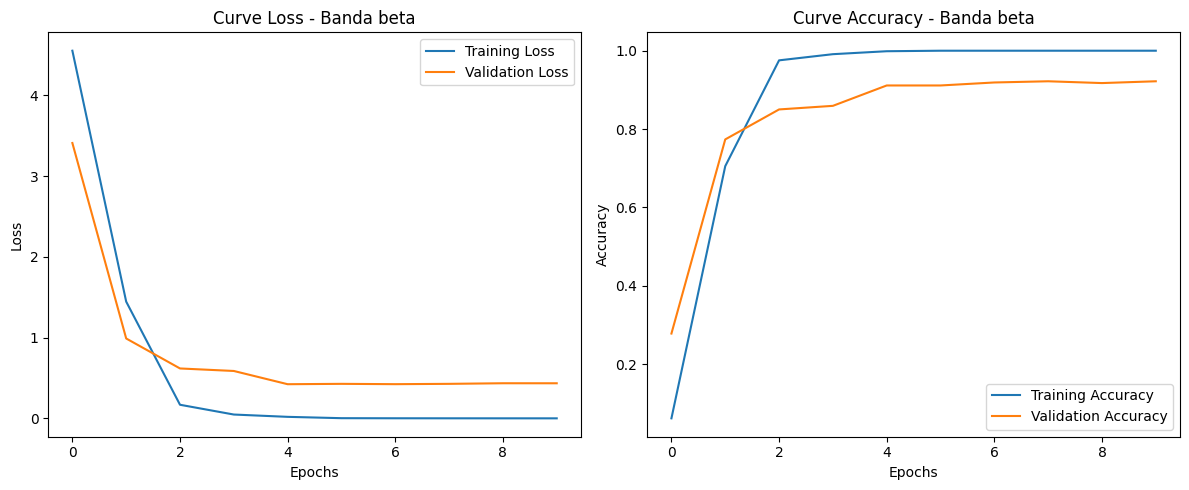

Training della CNN sulla banda gamma...
21/21 [==============================] - 1s 27ms/step - loss: 0.5365 - accuracy: 0.9220
Validation set accuracy: 0.9220


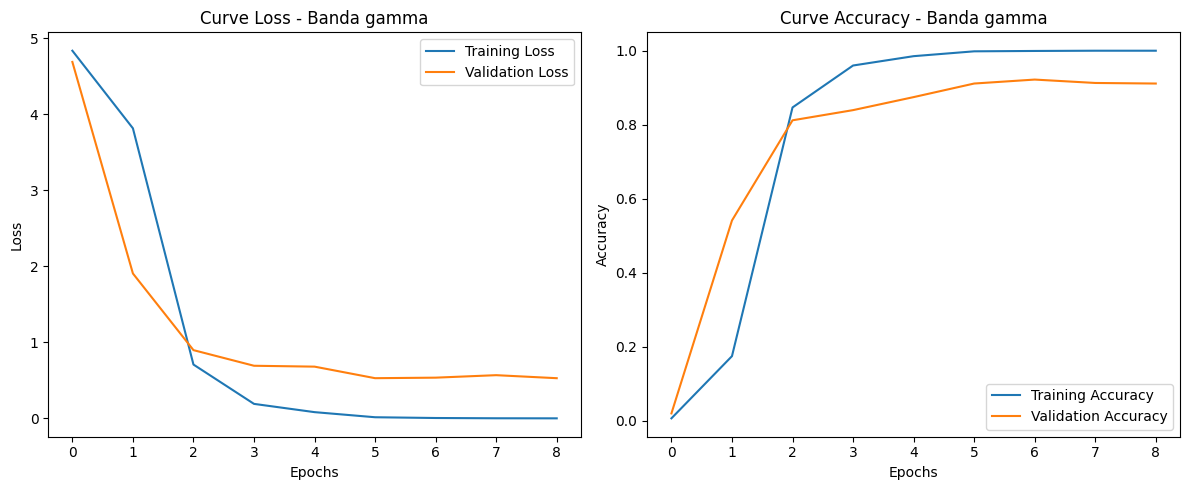

Training della CNN sulla banda beta + gamma...
21/21 [==============================] - 1s 27ms/step - loss: 0.3768 - accuracy: 0.9343
Validation set accuracy: 0.9343


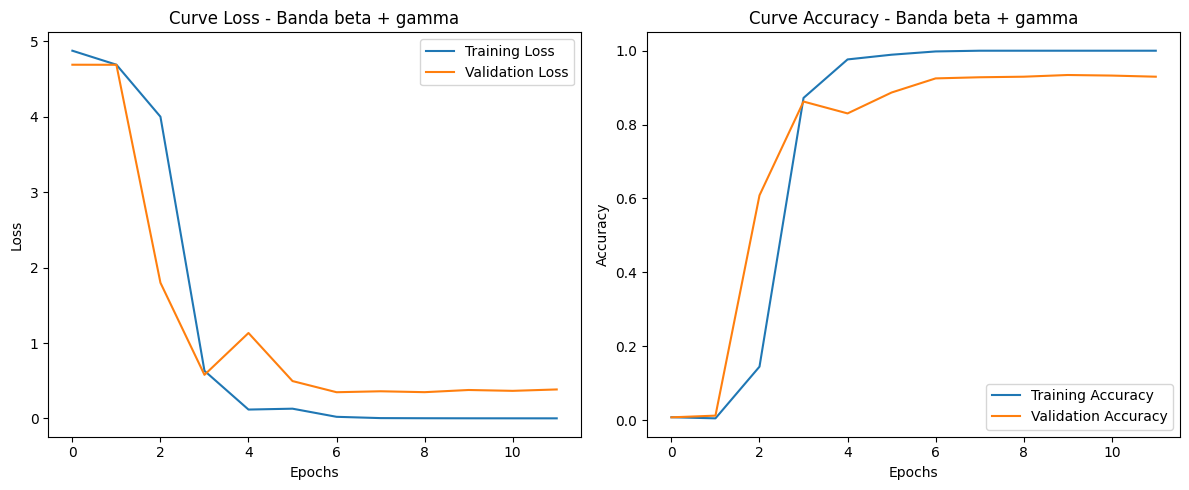

Training della CNN sulla banda broadband...
21/21 [==============================] - 1s 27ms/step - loss: 1.2473 - accuracy: 0.8028
Validation set accuracy: 0.8028


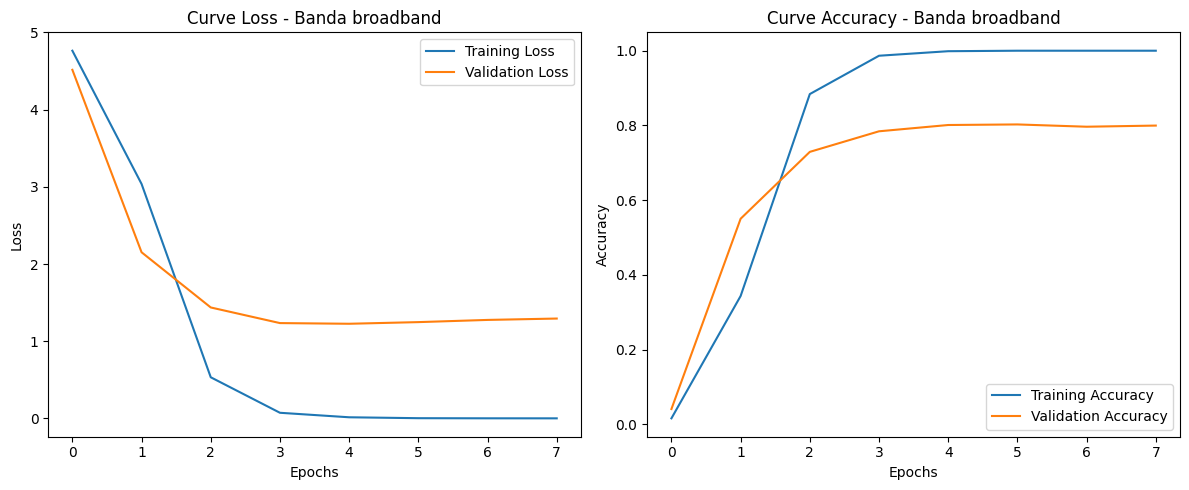

Training della CNN sulla banda beta rapido...
21/21 [==============================] - 1s 28ms/step - loss: 0.7201 - accuracy: 0.8349
Validation set accuracy: 0.8349


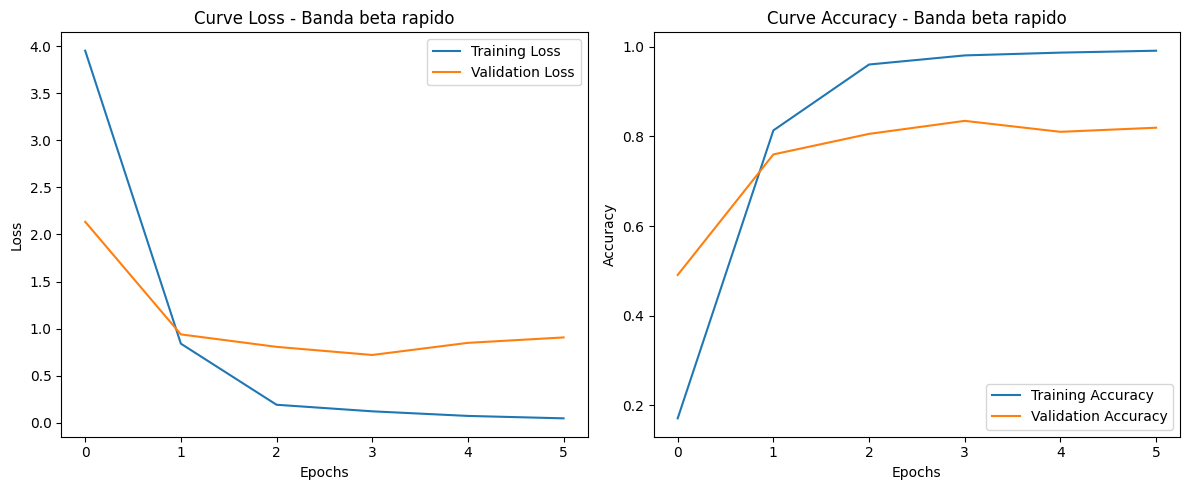

|    Banda     |  Validation  |     Test     |
----------------------------------------------
| beta + gamma |    0.9343    |    0.9128    |
|     beta     |    0.9220    |    0.9098    |
|    gamma     |    0.9220    |    0.8945    |
|  broadband   |    0.8028    |    0.8119    |
| beta rapido  |    0.8349    |    0.8089    |

Generazione matrice di confusione banda beta...
21/21 [==============================] - 1s 28ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda gamma...
21/21 [==============================] - 1s 26ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta + gamma...
21/21 [==============================] - 1s 27ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda broadband...
21/21 [==============================] - 1s 29ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta rapido...
21/21 [==============================] - 1s 29ms/step
Matrice di conf

In [15]:

# SISTEMA 1010 - DEEP LEARNING
# Funzione di reshape per rendere compatibili i dati con CNN (aggiunta del canale)
def reshape(bands, X_train, X_val, X_test):
    # Iterazione lungo le bande
    for band in bands:
        # Shape da (3052, 64, 240) a (3052, 64, 240, 1)
        X_train[band] = X_train[band].reshape(-1, X_train[band].shape[1], X_train[band].shape[2], 1)
        # Shape da (654, 64, 240) a (654, 64, 240, 1)
        X_val[band] = X_val[band].reshape(-1, X_val[band].shape[1], X_val[band].shape[2], 1)
        # Shape da (654, 64, 240) a (654, 64, 240, 1)
        X_test[band] = X_test[band].reshape(-1, X_test[band].shape[1], X_test[band].shape[2], 1)
        
        print(f"Reshape banda {band}:")
        print(f"    X_train.shape = {X_train[band].shape}")
        print(f"    X_val.shape   = {X_val[band].shape}")
        print(f"    X_test.shape  = {X_test[band].shape}")

# Funzione per definire il modello CNN2D
def cnn_model(input_shape, n_classes):
    # Costruzione del modello (sequenziale)
    model = tf.keras.Sequential([
        # Definizione dell'input (64, 240, 1)
        tf.keras.Input(shape=input_shape),
        # Primo blocco convoluzionale + max pooling
        tf.keras.layers.Conv2D(filters=18, 
                               kernel_size=(5,5), 
                               activation="relu",
                               padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        # Secondo blocco convoluzionale + max pooling
        tf.keras.layers.Conv2D(filters=18, 
                               kernel_size=(5,5), 
                               activation="relu",
                               padding="same"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        # Appiattimento per poter passare i dati allo strato Dense
        tf.keras.layers.Flatten(),
        # Layer denso finale con softmax
        tf.keras.layers.Dense(units=n_classes, 
                              activation="softmax")
    ])
    # Restituzione del modello
    return model
# Funzione per la compilazione ed il train del modello CNN
def compile_fit_evaluate_cnn(band, X_train_cnn, y_train_cnn, X_val_cnn, y_val_cnn, n_classes):
    # Stampa a video (controllo sulla banda attuale su cui si sta lavorando)
    print(f"Training della CNN sulla banda {band}...")
    # Inizializzazione del modello con chiamata alla funzione del modello
    model = cnn_model((X_train_cnn[band].shape[1], X_train_cnn[band].shape[2], X_train_cnn[band].shape[3]), n_classes)
    # Definizione dell'early stopping basato su validation accuracy con patience 2 (stretto)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                      patience = 2,
                                                      restore_best_weights=True,  # Restituisce il modello migliore
                                                      mode="max")
    # Compilazione del modello con accuracy come metrica di monitoraggio 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    # Training del modello per 20 epoche con batch size=32
    history = model.fit(X_train_cnn[band], 
                        y_train_cnn[band], 
                        epochs=20, 
                        batch_size=32, 
                        validation_data=(X_val_cnn[band], y_val_cnn[band]),
                        callbacks= [early_stopping],
                        verbose=0)
    # Valutazione del modello sui dati di validation
    _, val_accuracy = model.evaluate(X_val_cnn[band], y_val_cnn[band])
    # Stampa a video dell'accuratezza sul validation set
    print(f"Validation set accuracy: {val_accuracy:.4f}")
    # Restituzione del modello, dell'history e dell'accuratezza sul validation set
    return model, history, val_accuracy

# Funzione per la visualizzazione dell'overfitting tramite monitoraggio di:
# Training Loss e Validation Loss (val loss < train loss)
# Training Accuracy e Validation Accuracy (val accuracy > train accuracy)
def visualize_overfitting(band, history):
    # Generazione dell'immagine
    plt.figure(figsize=(12, 5))
    # Definizione della posizione del primo di due subblot disposti orizzontalmente
    plt.subplot(1, 2, 1)
    # Plot della training loss
    plt.plot(history.history["loss"], label="Training Loss")
    # Plot della validation loss
    plt.plot(history.history["val_loss"], label="Validation Loss")
    # Aggiunta della legenda
    plt.legend()
    # Aggiunta del titolo e definizione degli assi x e y
    plt.title(f"Curve Loss - Banda {band}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    # Definizione della posizione del secondo di due subblot disposti orizzontalmente
    plt.subplot(1, 2, 2)
    # Plot della training accuracy
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    # Plot della validation accuracy
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    # Aggiunta della legenda
    plt.legend()
    # Aggiunta del titolo e definizione degli assi x e y
    plt.title(f"Curve Accuracy - Banda {band}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    # Migliore visualizzazione
    plt.tight_layout()
    # Visualizzazione dell'immagine costruita
    plt.show()

# Funzione per stampare a video il confronto tra i risultati di validation e test
def val_test_comparison_cnn(bands, best_models, val_accuracies, X_test_cnn, y_test_cnn, directory):
    # Stampa ordinata con distanziamento. Le scritte sono centrate
    print(f"| {'Banda':^12} | {'Validation':^12} | {'Test':^12} |")
    # Stampa del separatore (estetico)
    print("-"*46)
    # Definizione della lista contenente i risultati
    results = []
    # Iterazione lungo le bande
    for band in bands:
        # Risultato dell'accuratezza sul test set
        _, test_accuracy = best_models[band].evaluate(X_test_cnn[band], y_test_cnn[band], verbose=0)
        # Aggiunta dei risultati (banda - validation test accuracy - test set accuracy)
        # alla lista dei risultati
        results.append((band, val_accuracies[band], test_accuracy))
    
    # Sort decrescente (dal migliore al peggiore) per accuracy sul test set
    results.sort(key=lambda x: x[2], reverse=True)
    # Iterazione lungo la lista dei risultati e scomposizione dei valori all'interno
    for band, val_acc, test_acc in results:
        # Stampa ordinata che segue la precedente per mantenere ordine
        # I valori di accuratezza sul validation set e test set sono
        # stampati con quattro valori decimali
        print(f"| {band:^12} | {val_acc:^12.4f} | {test_acc:^12.4f} |")
    print()
    # Definizione della directory da creare
    dir = directory
    # Impostazione del percorso della cartella principale per
    # contenere le varie sottocartelle delle confusion matrix
    path_dir = os.path.join(os.getcwd(), f"confusion_matrix/{dir}")
    # Se il percorso attuale non esiste viene creato
    if not os.path.exists(path_dir):
        os.makedirs(path_dir)
    # Iterazione lungo le bande
    for band in bands:
        # Definizione del file path dove salvare le matrici di confusione
        file_path = f"confusion_matrix/{dir}/{band}_cm.png"
        # Se il file path non esiste si procede con la creazione
        if not os.path.exists(file_path):
            # Stampa a video per verificare il corretto funzionamento
            print(f"Generazione matrice di confusione banda {band}...")
            # Generazione dell'immagine 
            plt.figure(figsize=(12, 10))
            # Predizioni del modello
            y_pred = best_models[band].predict(X_test_cnn[band])
            # Conversione da probabilità a classi
            y_pred = np.argmax(y_pred, axis=1)  
            y_true = y_test_cnn[band]
            # Calcolo dell matrice di confusione
            cm = confusion_matrix(y_true, y_pred)
            # Plot della matrice di confusione con colorazione blu
            sns.heatmap(cm, cmap="Blues")
            # Definizione del titolo personalizzato e definzione degli assi x e y
            plt.title(f"Confusion Matrix - Banda {band}")
            plt.xlabel("Classe Predetta")
            plt.ylabel("Classe Reale")
            # Salvataggio dell'immagine nel percorso predefinito e chiusura (per evitare la stampa a video)
            plt.savefig(file_path)
            plt.close()
            # Controllo con stampa a video
            print("Matrice di confusione salvata.")
        # Se la matrice di confusione è già stata generata
        else:
            # Stampa un messaggio di controllo
            print(f"Matrice di confusione della banda {band} già generata.")
    # Controllo finale
    print(f"\nGenerate tutte le matrici di confusione, sono visibili nella cartella {dir}")
    # Restituzione della lista dei risultati
    return results

# Definizione dizionari per salvare i risultati
best_models_cnn_1010 = {}
val_accuracies_cnn_1010 = {}
# Chiamata all funzione reshape per preparare i dati per la CNN
reshape(bands_1020, X_train_cnn_1010, X_val_cnn_1010, X_test_cnn_1010)
# Iterazione lungo le bande
for band in bands_1020:
    # Chiamata alla funzione per addestrare la rete neurale
    model, history, val_accuracy = compile_fit_evaluate_cnn(band, X_train_cnn_1010, y_train_cnn_1010, X_val_cnn_1010, y_val_cnn_1010, len(edf_files_R01))
    # Salvataggio dei risultati
    best_models_cnn_1010[band] = model
    val_accuracies_cnn_1010[band] = val_accuracy
    # Chiamata alla funzione per visualizzare possibile overfitting
    visualize_overfitting(band, history)
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione 
results_cnn_1010 = val_test_comparison_cnn(bands_1020, best_models_cnn_1010, val_accuracies_cnn_1010, X_test_cnn_1010, y_test_cnn_1010, "CM_DL_1010")

In [16]:
# SISTEMA 1020 - PREPROCESSING
# Funzione per il pre-processing dei file EDF escluso PSD
def preprocessing_dl_1020(edf_file, low, high, band, channels):
    # Conversione nel formato raw dell'edf_file attuale
    raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    # Selezione dei canali
    raw.pick(channels)
    # Preprocessing: filtraggio tramite Butterworth 
    raw.filter(l_freq=low[band], h_freq=high[band], method="iir", iir_params={"order": 4, "ftype": "butter"}, n_jobs=-1, verbose="CRITICAL")
    # Preprocessing: filtraggio spaziale tramite CAR
    raw.set_eeg_reference("average", verbose="CRITICAL")
    # Ottenimento dei dati in formato leggibile
    data = raw.get_data()   
    # Restituzione dei dati raw
    return data

# Funzione generale per il pre-processi dei dati EEG (Deep Learning) con riduzione dei canali
def process_eeg_data_dl_1020(edf_files, bands, low, high, samples, channels):
    # Inizializzazione dei dizionari per train/val/test
    X_train = {}
    y_train = {}
    X_val = {}
    y_val = {}
    X_test = {}
    y_test = {}
    # Stampa a video (controllo)
    print("Pre processing sistema 1020 (19 canali)...")
    # Iterazione che permette il filtraggio dei dati per ogni banda, 
    # la successiva segmentazione e il salvataggio dei dati in variabili separate.
    for band in bands:
        # Controllo per banda
        print(f"Pre-processing (Butterworth - CAR) banda {band}:")
        # Inizializzazione liste per train/val/test
        train_datas = []
        train_labels = []
        val_datas = []
        val_labels = []
        test_datas = []
        test_labels = []
        # Iterazione lungo i file edf per la segmentazione
        for label, edf_file in tqdm(enumerate(edf_files), desc=f"   File EDF", leave=False, total=len(edf_files)): 
            # Chiamata alla funzione preprocessing() (Butterworth - CAR)
            data = preprocessing_dl_1020(edf_file, low, high, band, channels)
            # Segmentazione senza feature extraction
            segments = segmentation_dl(samples, data)
            # Numero totale degli elementi per segmento
            elements = len(segments)
            # Train set, validation set e test set split
            if elements > 0:
                # Calcolo dei punti di split (70% train, 15% val, 15% test)
                # Primo 70% dei campioni per il train set
                train_end = int(elements * 0.7)
                # Successivo 15% dei campioni per il validation set
                val_end = int(elements * 0.85)
                # Costruzione del segmento di train (X e y)
                train_datas.extend(segments[:train_end])               
                train_labels.extend([label] * train_end)
                # Costruzione del segmento di validation (X e y)
                val_datas.extend(segments[train_end:val_end])
                val_labels.extend([label] * (val_end - train_end))
                # Costruzione del segmento di test (X e y)
                test_datas.extend(segments[val_end:])
                test_labels.extend([label] * (elements - val_end))
        # Creazione degli array numpy per la rispettiva banda
        X_train[band] = np.array(train_datas)
        y_train[band] = np.array(train_labels)
        X_val[band] = np.array(val_datas)
        y_val[band] = np.array(val_labels)
        X_test[band] = np.array(test_datas)
        y_test[band] = np.array(test_labels)
        # Stampa dello shape per controllare la dimensione 
        # Output atteso:
        # Shape X_train: (3052, 19, 240)
        # Shape X_val:   (654, 19, 240)
        # Shape X_test:  (654, 19, 240)
        print(f"Shape X_train di {band}: {X_train[band].shape}")
        print(f"Shape X_val di {band}: {X_val[band].shape}")
        print(f"Shape X_test di {band}: {X_test[band].shape}\n")
    # Restituzione dei dizionari contenenti i dati di train, validation e test
    return X_train, y_train, X_val, y_val, X_test, y_test
# Chiamata alla funzione generale per il pre-processing dei dati EEG con riduzione dei canali
X_train_cnn_1020, y_train_cnn_1020, X_val_cnn_1020, y_val_cnn_1020, X_test_cnn_1020, y_test_cnn_1020 = process_eeg_data_dl_1020(edf_files_R01, bands_1020, full_low, full_high, samples_segment, channels)
# Chiamata alla funzione di standardizzazione
standardization_dl(bands_1020, X_train_cnn_1020, X_val_cnn_1020, X_test_cnn_1020)

Pre processing sistema 1020 (19 canali)...
Pre-processing (Butterworth - CAR) banda beta:


Shape X_train di beta: (3052, 19, 240)
Shape X_val di beta: (654, 19, 240)
Shape X_test di beta: (654, 19, 240)

Pre-processing (Butterworth - CAR) banda gamma:


Shape X_train di gamma: (3052, 19, 240)
Shape X_val di gamma: (654, 19, 240)
Shape X_test di gamma: (654, 19, 240)

Pre-processing (Butterworth - CAR) banda beta + gamma:


Shape X_train di beta + gamma: (3052, 19, 240)
Shape X_val di beta + gamma: (654, 19, 240)
Shape X_test di beta + gamma: (654, 19, 240)

Pre-processing (Butterworth - CAR) banda broadband:


Shape X_train di broadband: (3052, 19, 240)
Shape X_val di broadband: (654, 19, 240)
Shape X_test di broadband: (654, 19, 240)

Pre-processing (Butterworth - CAR) banda beta rapido:


Shape X_train di beta rapido: (3052, 19, 240)
Shape X_val di beta rapido: (654, 19, 240)
Shape X_test di beta rapido: (654, 19, 240)



Reshape banda beta:
    X_train.shape = (3052, 19, 240, 1)
    X_val.shape   = (654, 19, 240, 1)
    X_test.shape  = (654, 19, 240, 1)
Reshape banda gamma:
    X_train.shape = (3052, 19, 240, 1)
    X_val.shape   = (654, 19, 240, 1)
    X_test.shape  = (654, 19, 240, 1)
Reshape banda beta + gamma:
    X_train.shape = (3052, 19, 240, 1)
    X_val.shape   = (654, 19, 240, 1)
    X_test.shape  = (654, 19, 240, 1)
Reshape banda broadband:
    X_train.shape = (3052, 19, 240, 1)
    X_val.shape   = (654, 19, 240, 1)
    X_test.shape  = (654, 19, 240, 1)
Reshape banda beta rapido:
    X_train.shape = (3052, 19, 240, 1)
    X_val.shape   = (654, 19, 240, 1)
    X_test.shape  = (654, 19, 240, 1)
Training della CNN sulla banda beta...
21/21 [==============================] - 0s 10ms/step - loss: 3.3705 - accuracy: 0.3593
Validation set accuracy: 0.3593


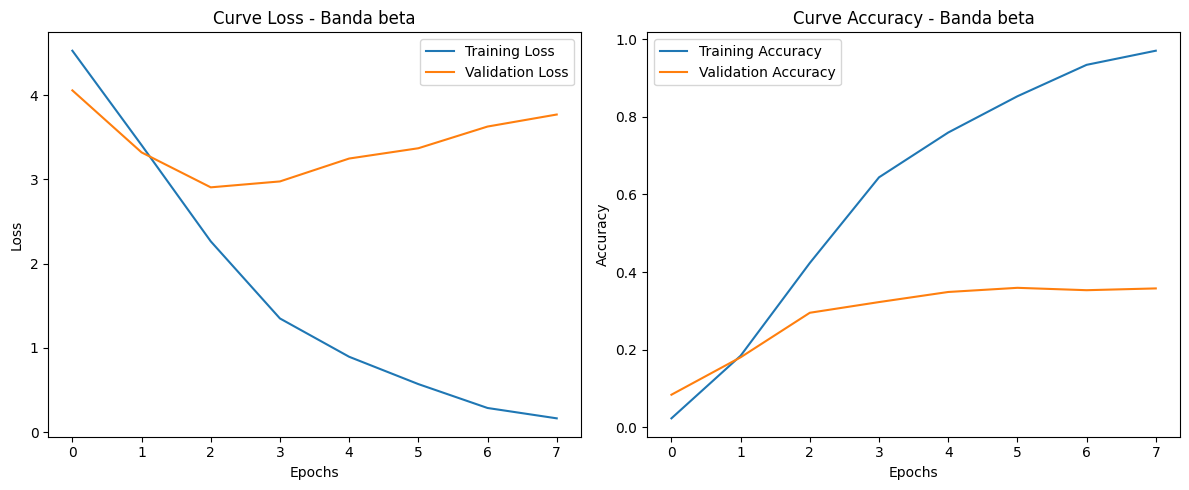

Training della CNN sulla banda gamma...
21/21 [==============================] - 0s 10ms/step - loss: 3.6163 - accuracy: 0.4419
Validation set accuracy: 0.4419


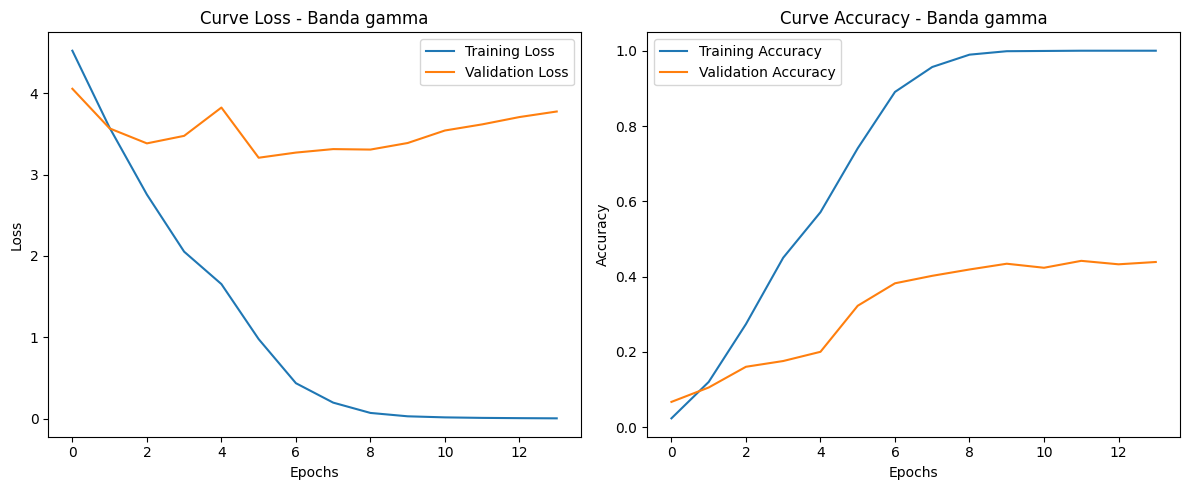

Training della CNN sulla banda beta + gamma...
21/21 [==============================] - 0s 11ms/step - loss: 1.5982 - accuracy: 0.6239
Validation set accuracy: 0.6239


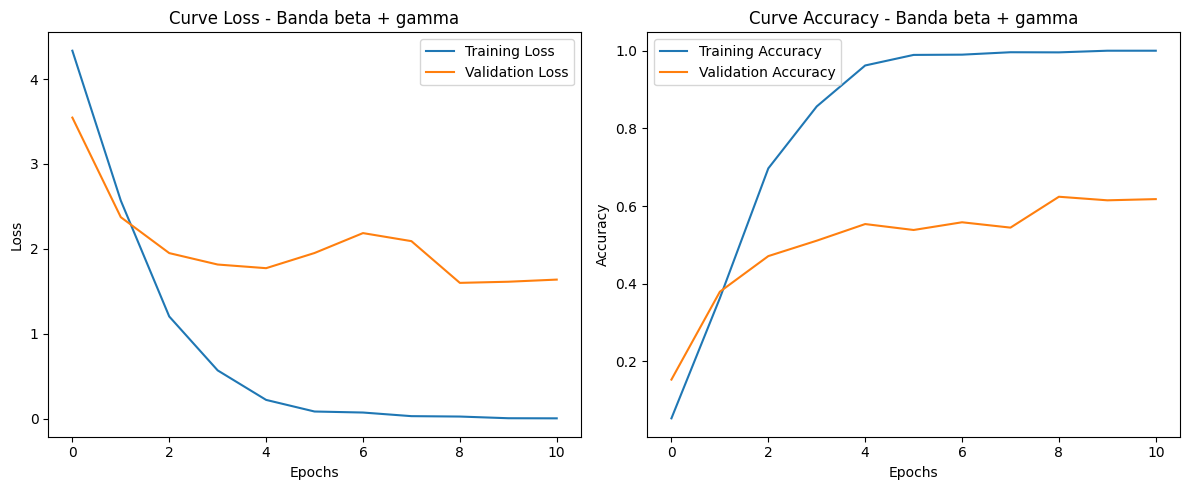

Training della CNN sulla banda broadband...
21/21 [==============================] - 0s 10ms/step - loss: 1.8664 - accuracy: 0.6116
Validation set accuracy: 0.6116


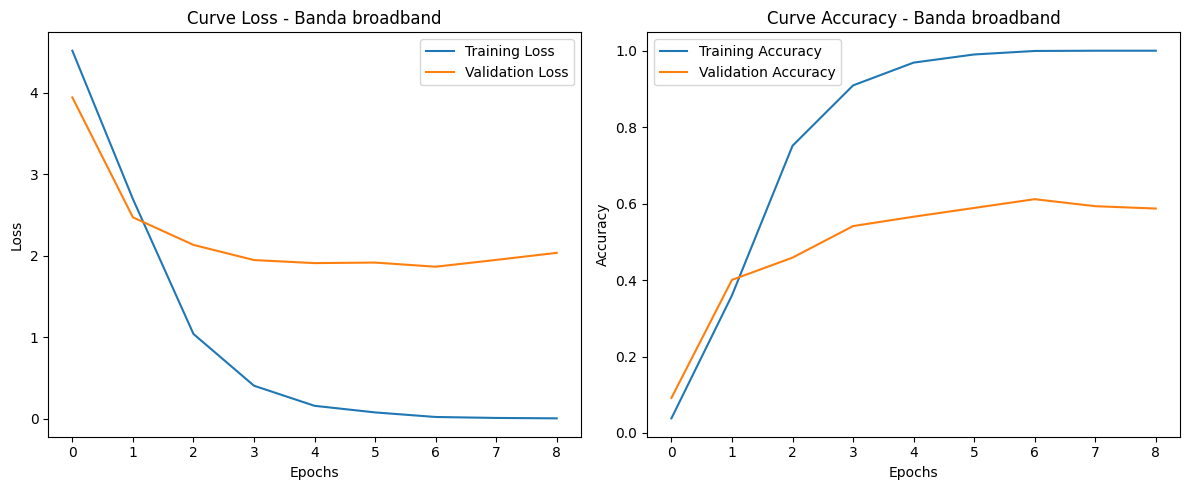

Training della CNN sulla banda beta rapido...
21/21 [==============================] - 0s 10ms/step - loss: 2.7073 - accuracy: 0.4817
Validation set accuracy: 0.4817


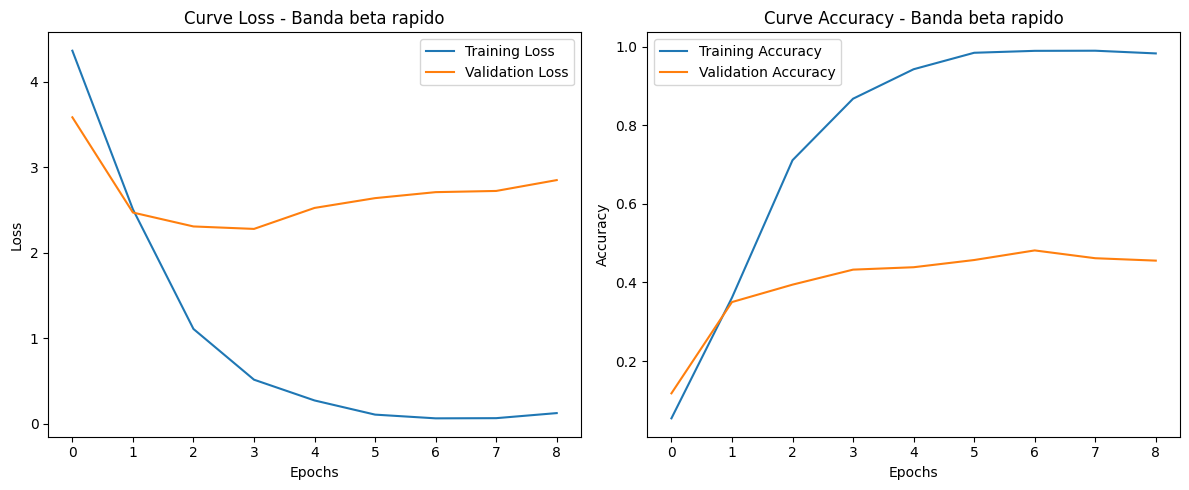

|    Banda     |  Validation  |     Test     |
----------------------------------------------
| beta + gamma |    0.6239    |    0.5810    |
|  broadband   |    0.6116    |    0.5780    |
| beta rapido  |    0.4817    |    0.4434    |
|    gamma     |    0.4419    |    0.4021    |
|     beta     |    0.3593    |    0.3211    |

Generazione matrice di confusione banda beta...
21/21 [==============================] - 0s 10ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda gamma...
21/21 [==============================] - 0s 10ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta + gamma...
21/21 [==============================] - 0s 9ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda broadband...
21/21 [==============================] - 0s 9ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta rapido...
21/21 [==============================] - 0s 10ms/step
Matrice di confus

In [17]:
# SISTEMA 1020 - DEEP LEARNING
# Definizione dizionari per salvare i risultati
best_models_cnn_1020 = {}
val_accuracies_cnn_1020 = {}
# Chiamata all funzione reshape per preparare i dati per la CNN
reshape(bands_1020, X_train_cnn_1020, X_val_cnn_1020, X_test_cnn_1020)
# Iterazione lungo le bande
for band in bands_1020:
    # Chiamata alla funzione per addestrare la rete neurale
    model, history, val_accuracy = compile_fit_evaluate_cnn(band, X_train_cnn_1020, y_train_cnn_1020, X_val_cnn_1020, y_val_cnn_1020, len(edf_files_R01))
    # Salvataggio dei risultati
    best_models_cnn_1020[band] = model
    val_accuracies_cnn_1020[band] = val_accuracy
    # Chiamata alla funzione per visualizzare possibile overfitting
    visualize_overfitting(band, history)
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione  
results_cnn_1020 = val_test_comparison_cnn(bands_1020, best_models_cnn_1020, val_accuracies_cnn_1020, X_test_cnn_1020, y_test_cnn_1020, "CM_DL_1020")

In [18]:
# Creazione di due dizionari per il confronto tra sistema 1010 e sistema 1020
dict_1010_cnn = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_cnn_1010}
dict_1020_cnn = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_cnn_1020}
# Stampa ordinata con distanziamento. Le scritte sono centrate
print(f"| {'Banda':^12} | {'Val 1010':^12} | {'Val 1020':^12} | {'Diff Val':^12} | {'Test 1010':^12} | {'Test 1020':^12} | {'Diff Test':^12} |")
# Stampa a video del separatore (estetica)
print("-"*106)
# Iterazione lungo le band del sistema 1020
for band in dict_1010_cnn.keys():
    # Validation accuracy e test accuracy di entrambi i dataset (divisi per banda)
    val_1010, test_1010 = dict_1010_cnn[band]
    val_1020, test_1020 = dict_1020_cnn[band]
    # Calcolo differenze validation accuracy tra dataset e test accuracy tra dataset
    diff_val = val_1020 - val_1010
    diff_test = test_1020 - test_1010
    # Stampa ordinata che segue la precedente per mantenere ordine
    # I valori di accuratezza sul validation set e test set sono stampati con quattro valori decimali
    print(f"| {band:^12} | {val_1010:^12.4f} | {val_1020:^12.4f} | {diff_val:^+12.4f} | {test_1010:^12.4f} | {test_1020:^12.4f} | {diff_test:^+12.4f} |")

|    Banda     |   Val 1010   |   Val 1020   |   Diff Val   |  Test 1010   |  Test 1020   |  Diff Test   |
----------------------------------------------------------------------------------------------------------
| beta + gamma |    0.9343    |    0.6239    |   -0.3104    |    0.9128    |    0.5810    |   -0.3318    |
|     beta     |    0.9220    |    0.3593    |   -0.5627    |    0.9098    |    0.3211    |   -0.5887    |
|    gamma     |    0.9220    |    0.4419    |   -0.4801    |    0.8945    |    0.4021    |   -0.4924    |
|  broadband   |    0.8028    |    0.6116    |   -0.1911    |    0.8119    |    0.5780    |   -0.2339    |
| beta rapido  |    0.8349    |    0.4817    |   -0.3532    |    0.8089    |    0.4434    |   -0.3654    |


La rete neurale convoluzionale 2D mostra risultati interessanti, risulta molto più performante sul sistema 1010 (64 canali) in quanto, probabilmente, riesce a rilevare correlazioni tra canali grazie al kernel ed al max pooling applicato su più canali contemporaneamente; mentre risulta poco affidabile nel caso di riduzione dei canali.

Nel concreto, questo specifico modello di deep learning performa bene solamente sul sistema 1010, ma nonostante gli ottimi risultati, l'accuratezza è comunque inferiore rispetto quella del modello shallow (SVC), di conseguenza non dimostra grossi miglioramenti.

Si può notare che, a differenza del modello shallow (SVC), la banda di frequenza più performante è la **Beta + Gamma** invece della banda di frequenza **Gamma** (si ipotizza che, avendo un range di frequenza maggiore, risulti essere maggiormente rappresentativa).

### Approccio Deep Learning: CNN1D + RNN

Considerando i non eccezionali risultati del modello CNN2D si prosegue l'analisi utilizzando un nuovo modello di Deep Learning costruito, a differenza del precedente, come rete convoluzionale 1D + rete neurale ricorrente. In questa maniera, invece di considerare i dati come un'immagine, si considera la sequenzialità temporale del segnale EEG. Si testa il seguente modello sia sui dati del sistema 1010 che sul sistema 1020 e si effettua un tuning degli iperparametri per poter costruire i modelli migliori per ogni banda di frequenza (come fatto precdentemente anche sui modelli shallow).

In [ ]:
# Funzione di reshape per rendere compatibili i dati con CNN1D + RNN 
def reshape_cnn_rnn(bands, X_train, X_val, X_test):
    # Da (n, n_channels, 240, 1) a (n, 240, n_channels) 
    # per cercare pattern temporali
    # Iterazione lungo le bande
    for band in bands:
        # Rimozione dell'ultima dimensione tramite squeeze(-1) 
        # Sistemazione dei dati tramite traspose()
        X_train[band] = X_train[band].squeeze(-1).transpose(0, 2, 1)
        X_val[band] = X_val[band].squeeze(-1).transpose(0, 2, 1)
        X_test[band] = X_test[band].squeeze(-1).transpose(0, 2, 1)
        
        print(f"Reshape banda {band}:")
        print(f"    X_train.shape = {X_train[band].shape}")
        print(f"    X_val.shape   = {X_val[band].shape}")
        print(f"    X_test.shape  = {X_test[band].shape}")
 
 # Funzione per definire il modello CNN1D + RNN       
def cnn_rnn_model(hp, input_shape, n_classes):
    # Costruzione del modello (sequenziale)
    model = tf.keras.Sequential()
    # Definzione dell'input atteso
    model.add(tf.keras.Input(shape=input_shape))
    # Iperparametri globali:
    # pooling_type: Definizione del pooling max o average
    # dense_layer: Defizione della presenza dell'ultimo layer dense prima della classificazione
    pooling_type = hp.Choice("pooling", values=["max", "avg"])
    dense_layer = hp.Boolean("dense")
    # Primo blocco convoluzionale + batch normalization + pooling
    filters = hp.Choice("filters_1", values=[32, 64])  # Tuning filtri primo blocco
    kernel_size = hp.Choice("kernel_1", values=[7, 9]) # Tuning dimensione kernel primo blocco
    model.add(tf.keras.layers.Conv1D(filters=filters,
                                     kernel_size=kernel_size,
                                     activation="relu",
                                     padding="same"))
    # Normalizzazione input layer 
    model.add(tf.keras.layers.BatchNormalization())
    # Pooling layer
    if pooling_type == "max":
        model.add(tf.keras.layers.MaxPool1D(pool_size=2))
    else:
        model.add(tf.keras.layers.AveragePooling1D(pool_size=2))
    # Secondo blocco convoluzionale + batch normalization + pooling
    filters = hp.Choice("filters_2", values=[64, 128]) # Tuning filtri secondo blocco
    kernel_size = hp.Choice("kernel_2", values=[5, 7]) # Tuning dimensione kernel secondo blocco
    model.add(tf.keras.layers.Conv1D(filters=filters,
                                     kernel_size=kernel_size,
                                     activation="relu",
                                     padding="same"))
    # Normalizzazione input layer
    model.add(tf.keras.layers.BatchNormalization())
    # Pooling layer
    if pooling_type == "max":
        model.add(tf.keras.layers.MaxPool1D(pool_size=2))
    else:
        model.add(tf.keras.layers.AveragePooling1D(pool_size=2))
    # Terzo blocco convoluzionale + batch normalization + pooling
    filters = hp.Choice("filters_3", values=[128, 256]) # Tuning filtri terzo blocco
    kernel_size = hp.Choice("kernel_3", values=[3, 5])  # Tuning dimensione kernel terzo blocco
    model.add(tf.keras.layers.Conv1D(filters=filters,
                                     kernel_size=kernel_size,
                                     activation="relu",
                                     padding="same"))
    # Normalizzazione input layer
    model.add(tf.keras.layers.BatchNormalization())
    # Pooling layer
    if pooling_type == "max":
        model.add(tf.keras.layers.MaxPool1D(pool_size=2))
    else:
        model.add(tf.keras.layers.AveragePooling1D(pool_size=2))
    # Primo layer GRU
    units = hp.Choice("units_1", values=[128, 256]) # Tuning units primo layer
    model.add(tf.keras.layers.GRU(units=units,
                                  return_sequences=True,
                                  dropout=0.3))
    # Secondo layer GRU
    units = hp.Choice("units_2", values=[64, 128]) # Tuning units secondo layer
    model.add(tf.keras.layers.GRU(units=units,
                                  dropout=0.3))
    # Dense layer opzionale
    if dense_layer:
        model.add(tf.keras.layers.Dense(128, activation="relu"))
        model.add(tf.keras.layers.Dropout(0.3))
    else:
        model.add(tf.keras.layers.Dropout(0.2))
    # Layer denso finale con softmax
    model.add(tf.keras.layers.Dense(n_classes, activation="softmax"))
    # Compilazione del modello con accuracy come metrica di monitoraggio
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    # Restituzione del modello
    return model

# Funzione per il tuning degli iperparametri del modello CNN1D + RNN
def hyperparameter_tuning_cnn_rnn(bands, X_train, y_train, X_val, y_val, n_classes, max_trials, dataset_name):
    # Definizione dizionario per salvare i risultati
    results = {}
    # Iterazione lungo le bande
    for band in bands:
        # Stampa a video (controllo)
        print(f"Tuning iperparametri per la banda {band}_{dataset_name}...")
        # Definizione del tuner Bayesian:
        # Testa prima num_initial_points modelli, successivamente sullla base di quelli cerca di trovare il modello migliore
        # eseguendo in totale max_trials modelli completi
        tuner = kt.BayesianOptimization(
            lambda hp: cnn_rnn_model(hp, (X_train[band].shape[1], X_train[band].shape[2]), n_classes),
            objective="val_accuracy",
            max_trials=max_trials,
            num_initial_points=5,
            directory=f"tuning/tuning_{band}_{dataset_name}",
            seed=21)
        # Definizione dell'early stopping con metrica validation accuracy e patience 5 (modesta)
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5)
        # Esecuzione del tuner per 100 epoche per modello
        tuner.search(
            X_train[band], y_train[band],
            epochs=100,  
            batch_size=64,
            validation_data=(X_val[band], y_val[band]),
            callbacks=[early_stopping],
            verbose=0)
        # Salvataggio dei migliori iperparametri
        best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
        # Accuratezza migliore raggiunta dal tuning
        best_accuracy = tuner.oracle.get_best_trials(1)[0].score
        # Stampa a video dei risultati
        print(f"    Migliore accuracy: {best_accuracy:.4f}")
        print(f"    Migliori parametri: {best_hp.values}\n")
        # Salvataggio migliori iperparametri
        results[band] = best_hp.values
    # Restituzuone dei modelli migliori per banda
    return results

# Chiamata all funzione reshape per preparare i dati per il modello
reshape_cnn_rnn(bands_1020, X_train_cnn_1010, X_val_cnn_1010, X_test_cnn_1010)
reshape_cnn_rnn(bands_1020, X_train_cnn_1020, X_val_cnn_1020, X_test_cnn_1020)

# Esecuzione del tuning degli iperparametri per le bande di frequenza (sistema 1010, 64 canali)
best_hyperparameter_1010 = hyperparameter_tuning_cnn_rnn(
    bands_1020, 
    X_train_cnn_1010, y_train_cnn_1010, 
    X_val_cnn_1010, y_val_cnn_1010, 
    len(edf_files_R01),
    max_trials=30,
    dataset_name="1010")
# Esecuzione del tuning degli iperparametri per le bande di frequenza (sistema 1020, 19 canali)
best_hyperparameter_1020 = hyperparameter_tuning_cnn_rnn(
    bands_1020, 
    X_train_cnn_1020, y_train_cnn_1020, 
    X_val_cnn_1020, y_val_cnn_1020, 
    len(edf_files_R01),
    max_trials=30,
    dataset_name="1020")

Tuning iperparametri per la banda beta_1010...
INFO:tensorflow:Reloading Tuner from tuning/tuning_beta_1010\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
    Migliore accuracy: 0.9128
    Migliori parametri: {'pooling': 'avg', 'dense': False, 'filters_1': 64, 'kernel_1': 7, 'filters_2': 64, 'kernel_2': 7, 'filters_3': 256, 'kernel_3': 3, 'units_1': 256, 'units_2': 128}

Tuning iperparametri per la banda gamma_1010...
INFO:tensorflow:Reloading Tuner from tuning/tuning_gamma_1010\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
    Migliore accuracy: 0.9480
    Migliori parametri: {'pooling': 'max', 'dense': False, 'filters_1': 64, 'kernel_1': 7, 'filters_2': 64, 'kernel_2': 5, 'filters_3': 256, 'kernel_3': 3, 'units_1': 256, 'units_2': 128}

Tuning iperparametri per la banda beta + gamma_1010...
INFO:tensorflow:Reloading Tuner from tuning/tuning_beta + gamma_1010\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
    Migliore accura

Sistema 1010:
Training finale banda beta (1010)...
Epoch 1/150
48/48 [==============================] - 13s 211ms/step - loss: 4.6036 - accuracy: 0.0206 - val_loss: 4.6224 - val_accuracy: 0.0092
Epoch 2/150
48/48 [==============================] - 9s 192ms/step - loss: 4.4116 - accuracy: 0.0351 - val_loss: 4.5082 - val_accuracy: 0.0214
Epoch 3/150
48/48 [==============================] - 9s 190ms/step - loss: 4.2404 - accuracy: 0.0623 - val_loss: 4.3494 - val_accuracy: 0.0505
Epoch 4/150
48/48 [==============================] - 9s 185ms/step - loss: 4.1067 - accuracy: 0.0780 - val_loss: 4.1653 - val_accuracy: 0.0765
Epoch 5/150
48/48 [==============================] - 9s 191ms/step - loss: 3.9548 - accuracy: 0.1045 - val_loss: 3.9650 - val_accuracy: 0.1040
Epoch 6/150
48/48 [==============================] - 9s 192ms/step - loss: 3.8042 - accuracy: 0.1271 - val_loss: 3.7621 - val_accuracy: 0.1498
Epoch 7/150
48/48 [==============================] - 9s 189ms/step - loss: 3.6415 - accura

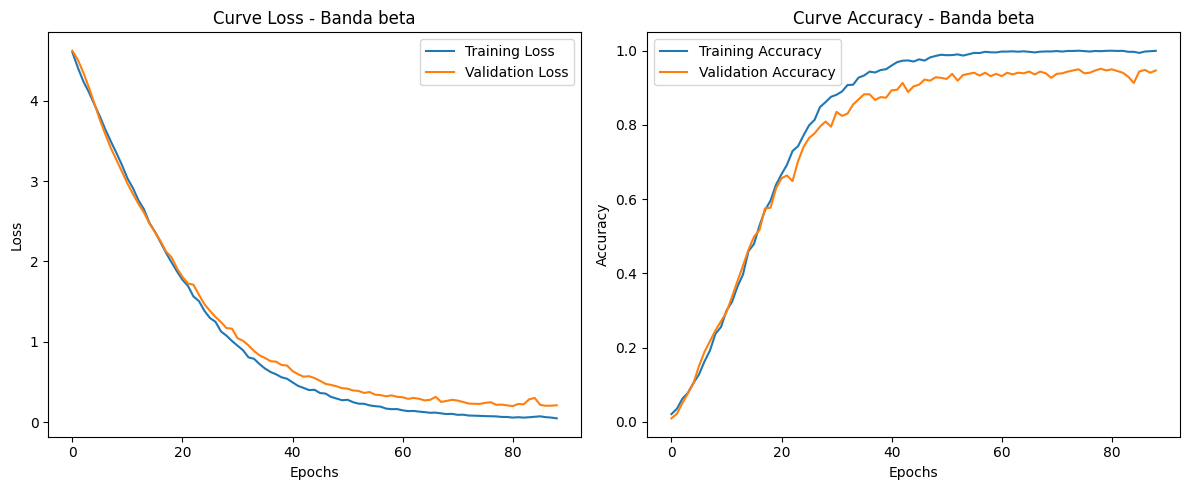

Training finale banda gamma (1010)...
Epoch 1/150
48/48 [==============================] - 13s 197ms/step - loss: 4.6406 - accuracy: 0.0190 - val_loss: 4.6108 - val_accuracy: 0.0122
Epoch 2/150
48/48 [==============================] - 9s 193ms/step - loss: 4.4318 - accuracy: 0.0442 - val_loss: 4.4659 - val_accuracy: 0.0459
Epoch 3/150
48/48 [==============================] - 9s 196ms/step - loss: 4.2543 - accuracy: 0.0665 - val_loss: 4.2814 - val_accuracy: 0.0657
Epoch 4/150
48/48 [==============================] - 9s 190ms/step - loss: 4.1072 - accuracy: 0.0881 - val_loss: 4.0988 - val_accuracy: 0.0872
Epoch 5/150
48/48 [==============================] - 9s 185ms/step - loss: 3.9467 - accuracy: 0.1212 - val_loss: 3.9271 - val_accuracy: 0.1040
Epoch 6/150
48/48 [==============================] - 9s 190ms/step - loss: 3.7833 - accuracy: 0.1612 - val_loss: 3.7467 - val_accuracy: 0.1483
Epoch 7/150
48/48 [==============================] - 9s 193ms/step - loss: 3.6362 - accuracy: 0.1864 - 

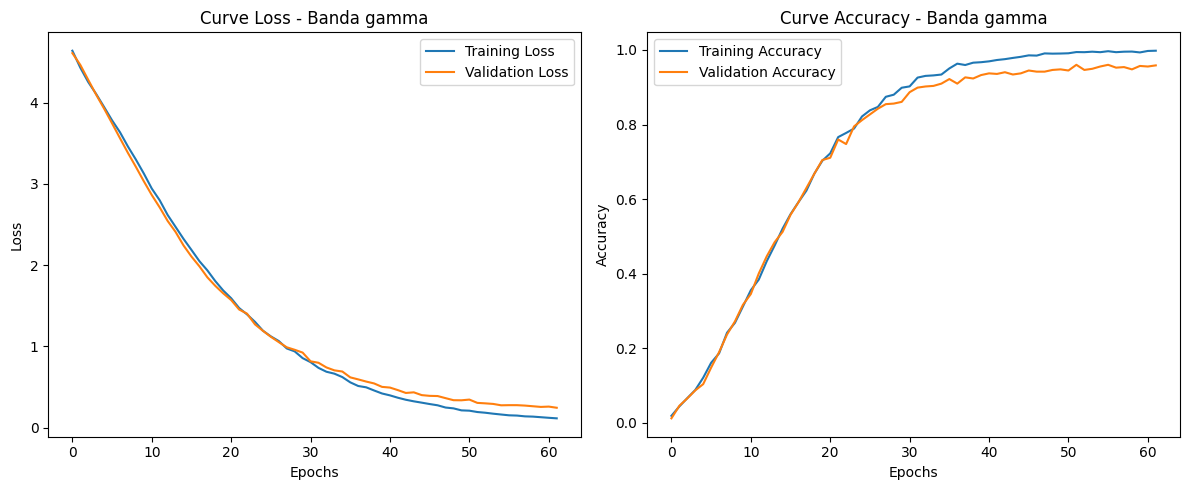

Training finale banda beta + gamma (1010)...
Epoch 1/150
48/48 [==============================] - 13s 193ms/step - loss: 4.5894 - accuracy: 0.0242 - val_loss: 4.6336 - val_accuracy: 0.0153
Epoch 2/150
48/48 [==============================] - 8s 177ms/step - loss: 4.3405 - accuracy: 0.0528 - val_loss: 4.5189 - val_accuracy: 0.0153
Epoch 3/150
48/48 [==============================] - 9s 181ms/step - loss: 4.1614 - accuracy: 0.0688 - val_loss: 4.3394 - val_accuracy: 0.0245
Epoch 4/150
48/48 [==============================] - 9s 182ms/step - loss: 3.9745 - accuracy: 0.0953 - val_loss: 4.1063 - val_accuracy: 0.0627
Epoch 5/150
48/48 [==============================] - 9s 180ms/step - loss: 3.8129 - accuracy: 0.1242 - val_loss: 3.8716 - val_accuracy: 0.1086
Epoch 6/150
48/48 [==============================] - 9s 180ms/step - loss: 3.6353 - accuracy: 0.1556 - val_loss: 3.6018 - val_accuracy: 0.1697
Epoch 7/150
48/48 [==============================] - 9s 182ms/step - loss: 3.4636 - accuracy: 0.

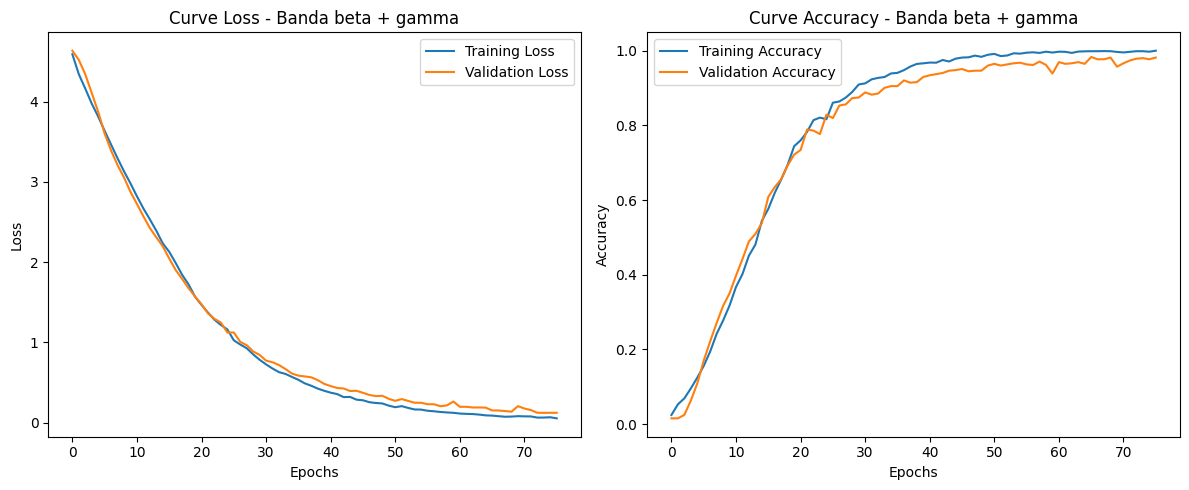

Training finale banda broadband (1010)...
Epoch 1/150
48/48 [==============================] - 12s 189ms/step - loss: 4.6346 - accuracy: 0.0203 - val_loss: 4.6138 - val_accuracy: 0.0260
Epoch 2/150
48/48 [==============================] - 8s 172ms/step - loss: 4.3991 - accuracy: 0.0416 - val_loss: 4.4894 - val_accuracy: 0.0428
Epoch 3/150
48/48 [==============================] - 8s 176ms/step - loss: 4.2239 - accuracy: 0.0593 - val_loss: 4.3335 - val_accuracy: 0.0566
Epoch 4/150
48/48 [==============================] - 8s 173ms/step - loss: 4.0821 - accuracy: 0.0773 - val_loss: 4.1761 - val_accuracy: 0.0627
Epoch 5/150
48/48 [==============================] - 8s 173ms/step - loss: 3.9483 - accuracy: 0.1039 - val_loss: 4.0416 - val_accuracy: 0.0979
Epoch 6/150
48/48 [==============================] - 8s 175ms/step - loss: 3.8178 - accuracy: 0.1225 - val_loss: 3.9170 - val_accuracy: 0.1131
Epoch 7/150
48/48 [==============================] - 8s 175ms/step - loss: 3.6932 - accuracy: 0.159

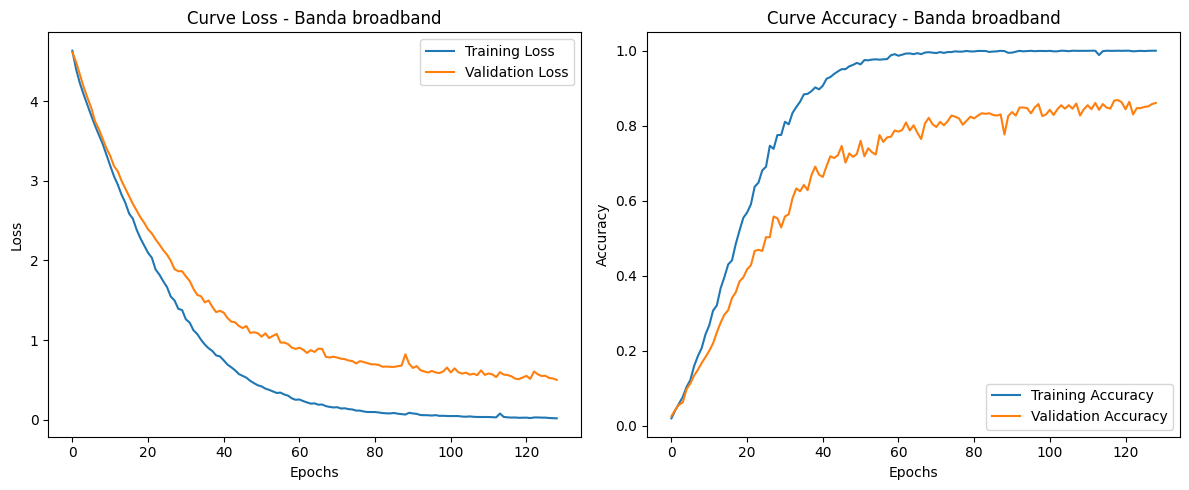

Training finale banda beta rapido (1010)...
Epoch 1/150
48/48 [==============================] - 12s 183ms/step - loss: 4.5822 - accuracy: 0.0213 - val_loss: 4.6113 - val_accuracy: 0.0183
Epoch 2/150
48/48 [==============================] - 8s 169ms/step - loss: 4.3349 - accuracy: 0.0498 - val_loss: 4.4756 - val_accuracy: 0.0321
Epoch 3/150
48/48 [==============================] - 8s 172ms/step - loss: 4.1517 - accuracy: 0.0744 - val_loss: 4.2936 - val_accuracy: 0.0520
Epoch 4/150
48/48 [==============================] - 8s 173ms/step - loss: 3.9766 - accuracy: 0.1009 - val_loss: 4.0592 - val_accuracy: 0.0887
Epoch 5/150
48/48 [==============================] - 8s 171ms/step - loss: 3.7952 - accuracy: 0.1415 - val_loss: 3.8058 - val_accuracy: 0.1300
Epoch 6/150
48/48 [==============================] - 8s 170ms/step - loss: 3.6052 - accuracy: 0.1701 - val_loss: 3.5828 - val_accuracy: 0.1621
Epoch 7/150
48/48 [==============================] - 8s 169ms/step - loss: 3.4513 - accuracy: 0.1

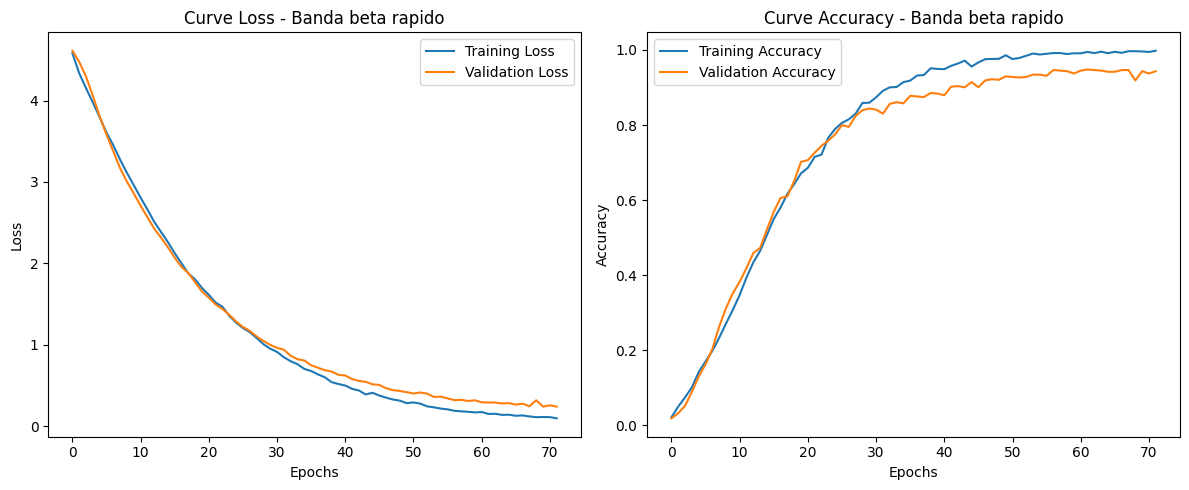

|    Banda     |  Validation  |     Test     |
----------------------------------------------
| beta + gamma |    0.9832    |    0.9572    |
|    gamma     |    0.9602    |    0.9297    |
|     beta     |    0.9511    |    0.9190    |
| beta rapido  |    0.9480    |    0.9083    |
|  broadband   |    0.8685    |    0.8043    |

Generazione matrice di confusione banda beta...
21/21 [==============================] - 1s 20ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda gamma...
21/21 [==============================] - 1s 20ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta + gamma...
21/21 [==============================] - 1s 20ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda broadband...
21/21 [==============================] - 1s 21ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta rapido...
21/21 [==============================] - 1s 19ms/step
Matrice di conf

In [22]:
print("Sistema 1010:")
# Definizione dizionari per i risultati finali
final_models_1010 = {}
final_val_accuracies_1010 = {}
# Iterazione lungo le bande
for band in bands_1020:
    # Stampa a video (controllo)
    print(f"Training finale banda {band} (1010)...")
    # Conversione iperparametri da dizionario a oggetto HyperParameters
    params = best_hyperparameter_1010[band]
    hp = kt.HyperParameters()
    for key, value in params.items():
        if isinstance(value, bool):
            hp.Boolean(key, default=value)
        else:
            hp.Choice(key, [value], default=value)
    # Creazione del modello con i migliori iperparametri
    model = cnn_rnn_model(hp, (X_train_cnn_1010[band].shape[1], X_train_cnn_1010[band].shape[2]), len(edf_files_R01))
    # Definizione early stopping più concessiva
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                     patience=10, 
                                                     restore_best_weights=True)
    # Training del modello per 150 epoche con batch size=64
    history = model.fit(
        X_train_cnn_1010[band], y_train_cnn_1010[band],
        epochs=150,
        batch_size=64,
        validation_data=(X_val_cnn_1010[band], y_val_cnn_1010[band]),
        callbacks=[early_stopping],
        verbose=1)
    # Valutazione del modello sui dati di validation
    _, final_val_acc = model.evaluate(X_val_cnn_1010[band], y_val_cnn_1010[band], verbose=0)
    # Salvataggio del modello e validation accuracy
    final_models_1010[band] = model
    final_val_accuracies_1010[band] = final_val_acc
    # Chiamata alla funzione per visualizzare possibile overfitting
    visualize_overfitting(band, history)
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione 
results_1010 = val_test_comparison_cnn(bands_1020, final_models_1010, final_val_accuracies_1010, X_test_cnn_1010, y_test_cnn_1010, "CM_DL_RNN_1010")

Sistema 1020:
Training finale banda beta (1020)...
Epoch 1/150
48/48 [==============================] - 11s 171ms/step - loss: 4.6526 - accuracy: 0.0170 - val_loss: 4.6103 - val_accuracy: 0.0183
Epoch 2/150
48/48 [==============================] - 8s 158ms/step - loss: 4.4508 - accuracy: 0.0337 - val_loss: 4.4660 - val_accuracy: 0.0352
Epoch 3/150
48/48 [==============================] - 8s 172ms/step - loss: 4.3080 - accuracy: 0.0459 - val_loss: 4.3190 - val_accuracy: 0.0413
Epoch 4/150
48/48 [==============================] - 8s 167ms/step - loss: 4.1867 - accuracy: 0.0626 - val_loss: 4.1868 - val_accuracy: 0.0550
Epoch 5/150
48/48 [==============================] - 8s 160ms/step - loss: 4.0750 - accuracy: 0.0757 - val_loss: 4.0615 - val_accuracy: 0.0795
Epoch 6/150
48/48 [==============================] - 8s 160ms/step - loss: 3.9642 - accuracy: 0.0947 - val_loss: 3.9271 - val_accuracy: 0.1055
Epoch 7/150
48/48 [==============================] - 7s 156ms/step - loss: 3.8465 - accura

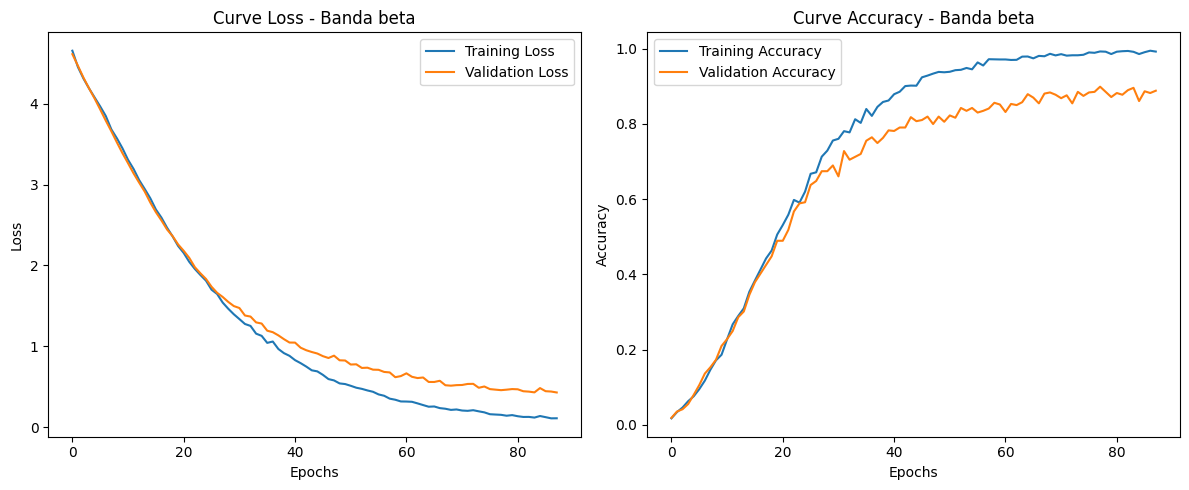

Training finale banda gamma (1020)...
Epoch 1/150
48/48 [==============================] - 12s 180ms/step - loss: 4.6023 - accuracy: 0.0170 - val_loss: 4.5804 - val_accuracy: 0.0214
Epoch 2/150
48/48 [==============================] - 8s 170ms/step - loss: 4.3577 - accuracy: 0.0406 - val_loss: 4.4052 - val_accuracy: 0.0382
Epoch 3/150
48/48 [==============================] - 8s 162ms/step - loss: 4.1829 - accuracy: 0.0770 - val_loss: 4.2188 - val_accuracy: 0.0719
Epoch 4/150
48/48 [==============================] - 8s 165ms/step - loss: 4.0254 - accuracy: 0.0993 - val_loss: 4.0351 - val_accuracy: 0.0948
Epoch 5/150
48/48 [==============================] - 8s 165ms/step - loss: 3.8540 - accuracy: 0.1429 - val_loss: 3.8349 - val_accuracy: 0.1315
Epoch 6/150
48/48 [==============================] - 8s 161ms/step - loss: 3.6948 - accuracy: 0.1687 - val_loss: 3.6398 - val_accuracy: 0.1651
Epoch 7/150
48/48 [==============================] - 8s 161ms/step - loss: 3.5394 - accuracy: 0.1910 - 

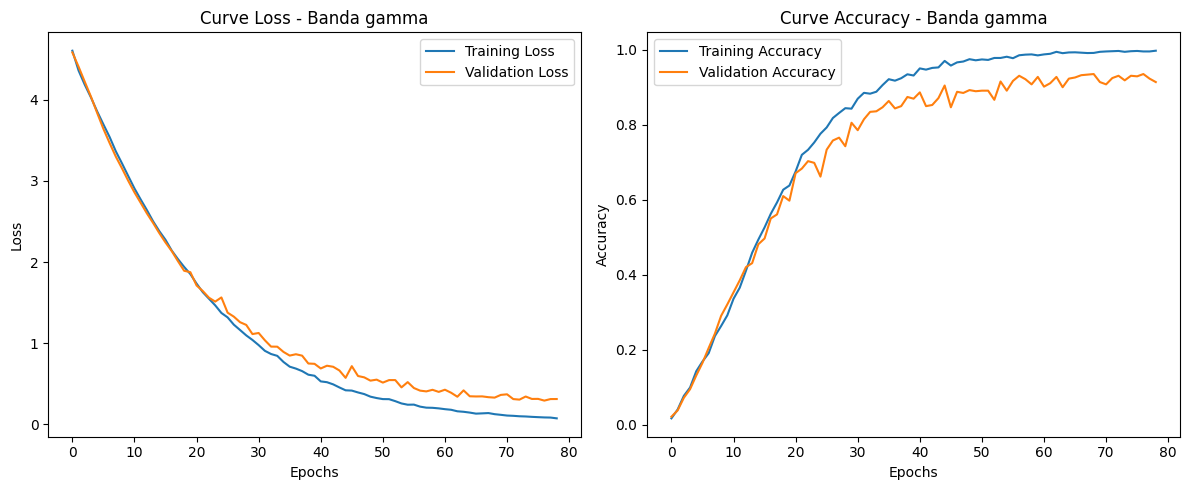

Training finale banda beta + gamma (1020)...
Epoch 1/150
48/48 [==============================] - 12s 174ms/step - loss: 4.6053 - accuracy: 0.0190 - val_loss: 4.6410 - val_accuracy: 0.0092
Epoch 2/150
48/48 [==============================] - 8s 156ms/step - loss: 4.3736 - accuracy: 0.0383 - val_loss: 4.5244 - val_accuracy: 0.0306
Epoch 3/150
48/48 [==============================] - 8s 157ms/step - loss: 4.1953 - accuracy: 0.0606 - val_loss: 4.3622 - val_accuracy: 0.0443
Epoch 4/150
48/48 [==============================] - 8s 161ms/step - loss: 4.0496 - accuracy: 0.0678 - val_loss: 4.2079 - val_accuracy: 0.0596
Epoch 5/150
48/48 [==============================] - 8s 159ms/step - loss: 3.9096 - accuracy: 0.0950 - val_loss: 3.9926 - val_accuracy: 0.0963
Epoch 6/150
48/48 [==============================] - 8s 161ms/step - loss: 3.7702 - accuracy: 0.1278 - val_loss: 3.8121 - val_accuracy: 0.1208
Epoch 7/150
48/48 [==============================] - 7s 156ms/step - loss: 3.5996 - accuracy: 0.

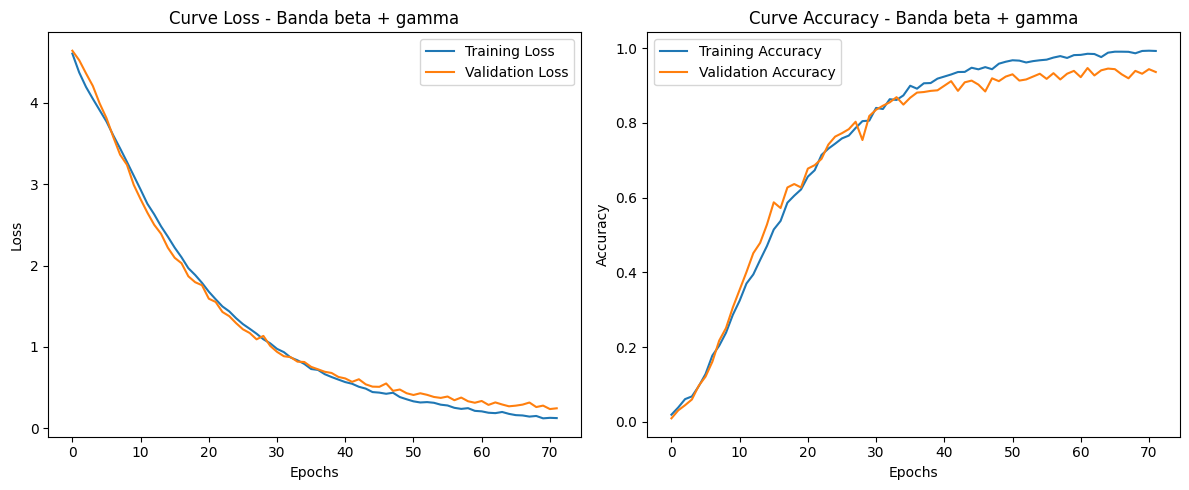

Training finale banda broadband (1020)...
Epoch 1/150
48/48 [==============================] - 13s 172ms/step - loss: 4.6804 - accuracy: 0.0115 - val_loss: 4.6595 - val_accuracy: 0.0153
Epoch 2/150
48/48 [==============================] - 7s 152ms/step - loss: 4.5874 - accuracy: 0.0213 - val_loss: 4.5854 - val_accuracy: 0.0199
Epoch 3/150
48/48 [==============================] - 7s 154ms/step - loss: 4.4802 - accuracy: 0.0328 - val_loss: 4.4827 - val_accuracy: 0.0229
Epoch 4/150
48/48 [==============================] - 7s 154ms/step - loss: 4.3846 - accuracy: 0.0367 - val_loss: 4.3759 - val_accuracy: 0.0229
Epoch 5/150
48/48 [==============================] - 7s 153ms/step - loss: 4.2772 - accuracy: 0.0455 - val_loss: 4.2721 - val_accuracy: 0.0260
Epoch 6/150
48/48 [==============================] - 7s 155ms/step - loss: 4.1958 - accuracy: 0.0521 - val_loss: 4.1616 - val_accuracy: 0.0321
Epoch 7/150
48/48 [==============================] - 7s 154ms/step - loss: 4.1010 - accuracy: 0.053

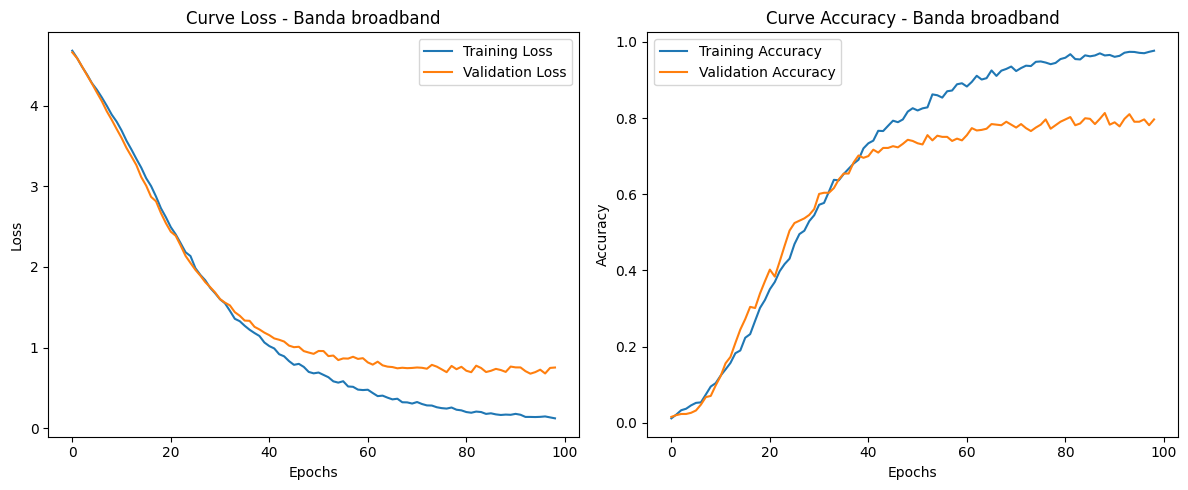

Training finale banda beta rapido (1020)...
Epoch 1/150
48/48 [==============================] - 11s 167ms/step - loss: 4.5765 - accuracy: 0.0226 - val_loss: 4.6338 - val_accuracy: 0.0275
Epoch 2/150
48/48 [==============================] - 12s 249ms/step - loss: 4.3319 - accuracy: 0.0498 - val_loss: 4.5182 - val_accuracy: 0.0336
Epoch 3/150
48/48 [==============================] - 9s 195ms/step - loss: 4.1306 - accuracy: 0.0668 - val_loss: 4.3344 - val_accuracy: 0.0550
Epoch 4/150
48/48 [==============================] - 7s 144ms/step - loss: 3.9694 - accuracy: 0.0888 - val_loss: 4.1165 - val_accuracy: 0.0719
Epoch 5/150
48/48 [==============================] - 7s 143ms/step - loss: 3.7983 - accuracy: 0.1209 - val_loss: 3.8911 - val_accuracy: 0.0948
Epoch 6/150
48/48 [==============================] - 7s 144ms/step - loss: 3.6353 - accuracy: 0.1415 - val_loss: 3.6920 - val_accuracy: 0.1391
Epoch 7/150
48/48 [==============================] - 7s 143ms/step - loss: 3.4611 - accuracy: 0.

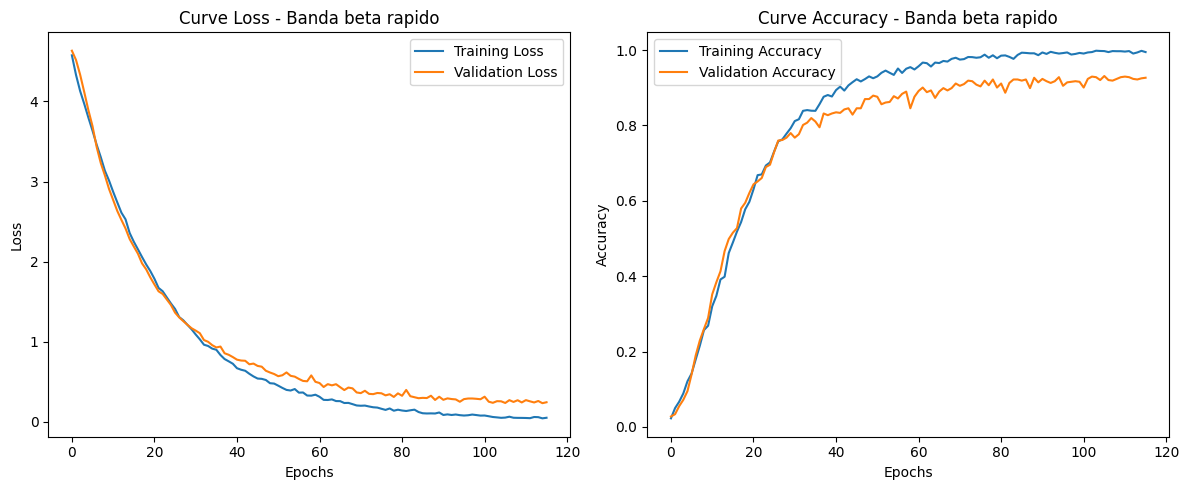

|    Banda     |  Validation  |     Test     |
----------------------------------------------
| beta + gamma |    0.9465    |    0.9144    |
|    gamma     |    0.9358    |    0.8960    |
| beta rapido  |    0.9312    |    0.8960    |
|     beta     |    0.8991    |    0.8394    |
|  broadband   |    0.8135    |    0.7798    |

Generazione matrice di confusione banda beta...
21/21 [==============================] - 1s 21ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda gamma...
21/21 [==============================] - 1s 21ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta + gamma...
21/21 [==============================] - 1s 21ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda broadband...
21/21 [==============================] - 1s 20ms/step
Matrice di confusione salvata.
Generazione matrice di confusione banda beta rapido...
21/21 [==============================] - 1s 20ms/step
Matrice di conf

In [23]:
print("Sistema 1020:")
# Definizione dizionari per i risultati finali
final_models_1020 = {}
final_val_accuracies_1020 = {}
# Iterazione lungo le bande
for band in bands_1020:
    # Stampa a video (controllo)
    print(f"Training finale banda {band} (1020)...")
    # Conversione iperparametri da dizionario a oggetto HyperParameters
    params = best_hyperparameter_1020[band]
    hp = kt.HyperParameters()
    for key, value in params.items():
        if isinstance(value, bool):
            hp.Boolean(key, default=value)
        else:
            hp.Choice(key, [value], default=value)
    # Creazione del modello con i migliori iperparametri
    model = cnn_rnn_model(hp, (X_train_cnn_1020[band].shape[1], X_train_cnn_1020[band].shape[2]), len(edf_files_R01))
    # Definizione early stopping più concessiva
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                     patience=10, 
                                                     restore_best_weights=True)
    # Training del modello per 150 epoche con batch size=64
    history = model.fit(
        X_train_cnn_1020[band], y_train_cnn_1020[band],
        epochs=150,
        batch_size=64,
        validation_data=(X_val_cnn_1020[band], y_val_cnn_1020[band]),
        callbacks=[early_stopping],
        verbose=1)
    # Valutazione del modelllo sui dati di validation
    _, final_val_acc = model.evaluate(X_val_cnn_1020[band], y_val_cnn_1020[band], verbose=0)
    # Salvataggio del modello e validation accuracy
    final_models_1020[band] = model
    final_val_accuracies_1020[band] = final_val_acc
    # Chiamata alla funzione per visualizzare possibile overfitting
    visualize_overfitting(band, history)
# Chiamata alla funzione per il confronto tra validation accuracy e test accuracy per ogni banda
# e successiva generazione delle matrici di confusione 
results_1020 = val_test_comparison_cnn(bands_1020, final_models_1020, final_val_accuracies_1020, X_test_cnn_1020, y_test_cnn_1020, "CM_DL_RNN_1020")

In [24]:
# Creazione di due dizionari per il confronto tra sistema 1010 e sistema 1020
dict_1010_rnn = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_1010}
dict_1020_rnn = {band: (val_acc, test_acc) for band, val_acc, test_acc in results_1020}
# Stampa ordinata con distanziamento. Le scritte sono centrate
print(f"| {'Banda':^12} | {'Val 1010':^12} | {'Val 1020':^12} | {'Diff Val':^12} | {'Test 1010':^12} | {'Test 1020':^12} | {'Diff Test':^12} |")
# Stampa a video del separatore (estetica)
print("-"*106)
# Iterazione lungo le band del sistema 1020
for band in dict_1010_cnn.keys():
    # Validation accuracy e test accuracy di entrambi i dataset (divisi per banda)
    val_1010, test_1010 = dict_1010_rnn[band]
    val_1020, test_1020 = dict_1020_rnn[band]
    # Calcolo differenze validation accuracy tra dataset e test accuracy tra dataset
    diff_val = val_1020 - val_1010
    diff_test = test_1020 - test_1010
    # Stampa ordinata che segue la precedente per mantenere ordine
    # I valori di accuratezza sul validation set e test set sono stampati con quattro valori decimali
    print(f"| {band:^12} | {val_1010:^12.4f} | {val_1020:^12.4f} | {diff_val:^+12.4f} | {test_1010:^12.4f} | {test_1020:^12.4f} | {diff_test:^+12.4f} |")

|    Banda     |   Val 1010   |   Val 1020   |   Diff Val   |  Test 1010   |  Test 1020   |  Diff Test   |
----------------------------------------------------------------------------------------------------------
| beta + gamma |    0.9832    |    0.9465    |   -0.0367    |    0.9572    |    0.9144    |   -0.0428    |
|     beta     |    0.9511    |    0.8991    |   -0.0520    |    0.9190    |    0.8394    |   -0.0795    |
|    gamma     |    0.9602    |    0.9358    |   -0.0245    |    0.9297    |    0.8960    |   -0.0336    |
|  broadband   |    0.8685    |    0.8135    |   -0.0550    |    0.8043    |    0.7798    |   -0.0245    |
| beta rapido  |    0.9480    |    0.9312    |   -0.0168    |    0.9083    |    0.8960    |   -0.0122    |


## Conclusioni

Le bande di frequenza più rappresentative risultano essere la **Gamma** per quanto riguarda il modello shallow implementato, mentre per i vari modelli di Deep Learning risulta essere la nuova banda definita **Beta + Gamma** (indipendentemente dal sistema di canali utilizzato), mentre la banda **Broadband** può essere abbandonata in quanto poco performante. 

Le bande di frequenza **Beta** e **Beta rapido** risultano essere altalenanti, senza dimostrare concretezza cambiando il modello utilizzato, di conseguenza non affidabili.

I risultati mostrano che il **modello shallow (SVC)** con pre-processing e feature extraction mostra ottimi risultati con 64 canali e buoni con 19 canali, con una riduzione dell’accuratezza nel secondo caso (~10%).

Il **modello Deep Learning CNN2D** con pre-processing mostra buoni risultati con 64 canali e risultati insufficienti con 19, in entrambi i casi i risultati ottenuti sono minori rispetto il modello shallow (SVC). Probabilmente non è l’approccio corretto.

Il **modello Deep Learning CNN1D + RNN** con tuning degli iperparametri invece mostra risultati migliori rispetto al modello CNN2D in entrambe le casistiche, risultati equiparabili al modello shallow (SVC) con 64 canali, e i risultati migliori nel caso di utilizzo di 19 canali. Risultando essere la scelta migliore per ulteriori analisi grazie alla sua capacità di catturare le dipendenze temporali nei segnali EEG attraverso le reti neurali ricorrenti. È probabile che migliorando il modello attraverso un’attenta scelta degli iperparametri (possibile magari grazie ad un tuning più accurato) si raggiungano risultati maggiori rispetto al modello shallow (SVC).

In conclusione il modello shallow dimostra che un’attenta combinazione di pre-processing e feature extraction permette di raggiungere risultati più che ottimi con poca difficoltà e ridotta complessità computazionale, mentre il modello CNN1D + RNN dimostra ottime capacità di adattamento ai dati (anche in caso di riduzione dei canali) e di personalizzazione, con la possibilità di raggiungere risultati anche superiori a discapito della complessità computazionale. 

In sintesi, dall’analisi svolta, nel caso in cui si utilizzino 64 canali non c’è un vero e proprio modello vincitore, poiché entrambi (SVC e CNN1D + RNN) presentano pro e contro a seconda della situazione, mentre nel caso di riduzione dei canali il modello di Deep Learning si comporta nettamente meglio.

*Si ipotizzano come lavori futuri verifiche su Dataset diversi, modelli diversi (shallow e Deep Learning) e preprocessing diversi per verificare la correttezza dei risultati ottenuti.*